# Forecast of whether or not a day is a working day with energy demand

## Feb 2023
--- 

In [74]:
from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# others
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# 1. MODEL FITTING WITH THE AJU_DATA_DEM_C3 DATASET
---

The aim is to estimate the variable FESTIVO (1: the day is a holiday) from the variables available in the dataset that are considered appropriate. The following cannot be used as input variables: DATE, DAY or YEAR. The DATE is interesting to handle simply as an aid to understand what is happening.

Different models must be adjusted, looking for a good compromise between complexity and error in each one of them. The goal is to get a good model with a high capacity to be correct in the future. Models that must be created, analyzing the results of each one of them (errors and importance of the variables):
- Simple tree
- Bagged tree
- Random Forest
- Gradient boosting
- Stacking

Load data

In [75]:
df_aju = pd.read_csv('AJU_DATOS_DEM_C3.csv')

#we parse the date(string) to be a datetime in dd/mm/yyyy format 
#this variable CANNOT be used as input in the models

df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format='%d/%m/%Y') 
s=df_aju.loc[:,'FECHA']
df_aju['FECHA'] =  s.dt.date

# It will be eliminated from the dataframe
del df_aju['ANNO']
del df_aju['DIA']

print('df_orig shape with load data:', df_aju.shape)
print('Dataframe with all data read (rows: days, columns: variables):')
df_aju

df_orig shape with load data: (2879, 30)
Dataframe with all data read (rows: days, columns: variables):


,FECHA,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,...,CR19,CR20,CR21,CR22,CR23,MES,DIASEM,FESTIVO,TMIN,TMAX
0,2014-01-01,0.040942,0.038985,0.036382,0.034416,0.033409,0.033420,0.034054,0.034229,0.035889,...,0.055197,0.054185,0.051063,0.046240,0.041000,1,3,1,12.3,20.2
1,2014-01-02,0.033950,0.030996,0.029517,0.028966,0.029165,0.030150,0.032944,0.036510,0.041196,...,0.055820,0.054451,0.051482,0.046145,0.040880,1,4,0,12.0,20.1
2,2014-01-03,0.035463,0.032112,0.030292,0.029521,0.029450,0.030515,0.033188,0.036656,0.041052,...,0.055230,0.053520,0.050286,0.045412,0.040025,1,5,0,13.2,21.0
3,2014-01-04,0.035959,0.032772,0.031034,0.030178,0.030135,0.030782,0.032598,0.034982,0.039299,...,0.053757,0.052620,0.049973,0.044970,0.040386,1,6,0,14.4,23.4
4,2014-01-05,0.037506,0.034148,0.031878,0.031126,0.030930,0.031604,0.033066,0.034803,0.038758,...,0.052902,0.051481,0.049655,0.045730,0.040905,1,7,0,12.8,23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,0.033180,0.031299,0.030173,0.029493,0.029649,0.030814,0.033925,0.037837,0.042098,...,0.051685,0.050563,0.047267,0.042237,0.037797,12,1,0,16.1,23.0
2875,2021-12-28,0.033823,0.031731,0.030385,0.029950,0.030017,0.031203,0.034708,0.038432,0.042645,...,0.051867,0.050971,0.047718,0.042585,0.037774,12,2,0,16.6,22.7
2876,2021-12-29,0.034475,0.032198,0.030902,0.030441,0.030384,0.031487,0.034454,0.038381,0.042850,...,0.052136,0.050604,0.046788,0.042033,0.037595,12,3,0,14.3,21.3
2877,2021-12-30,0.034345,0.031919,0.030524,0.029991,0.030087,0.031286,0.034384,0.038574,0.042778,...,0.052092,0.050993,0.047587,0.042807,0.038252,12,4,0,13.4,26.4


General vision

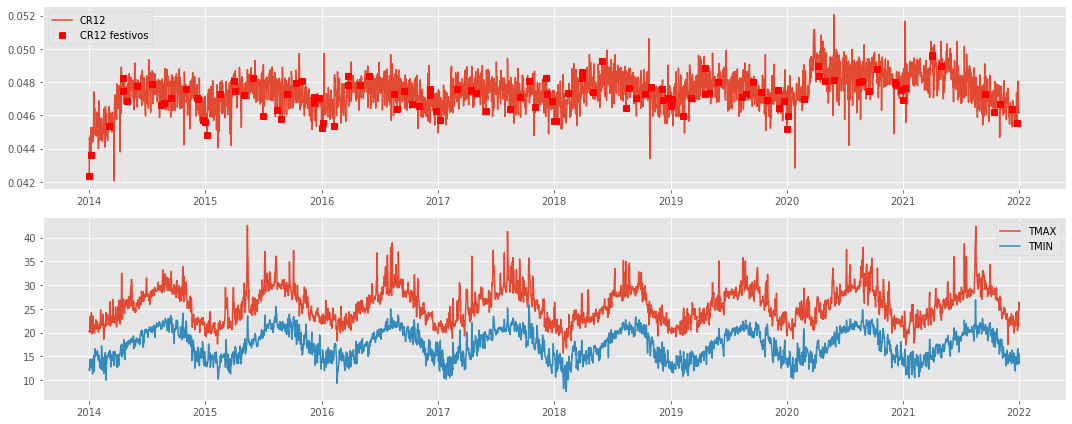

It is observad that the number of vacation days (115) is lower to the number of working days (2764)
To sum up, the percentage of vacation days is  3.99444251476207 %


In [76]:
fig = plt.figure(1, figsize=(15,6))
ax1 = plt.subplot(2,1,1)

ind_festivo = df_aju.FESTIVO == 1

plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')

plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2,1,2,sharex= ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX')
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN')
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'It is observad that the number of vacation days ({num_festivos}) is lower to the number of working days ({num_laborables})')
print(f'To sum up, the percentage of vacation days is  {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

## 1.1 BASIC EXPLORATORY ANALYSIS OF THE PROBLEM
---


### 1.1.1 Exploratory Analysis
In this section, an exploratory analysis of the data will be performed.Also, a correlation analysis will be performed. To do this, first the dataset will be balanced, creating a dataset with as many 0's as 1's in the output variable:

In [77]:
df_aju_0=df_aju[df_aju['FESTIVO']==0]
df_aju_1=df_aju[df_aju['FESTIVO']==1]
print('Shape of df_aju_0:', df_aju_0.shape)
print('Shape of df_aju_1:', df_aju_1.shape)
df_aju_0=df_aju_0.sample(df_aju_1.shape[0],replace=False, random_state=0)
df_aju_balanced=pd.concat([df_aju_0,df_aju_1], axis=0)
print('Shape of df_aju_balanced:', df_aju_balanced.shape)

Shape of df_aju_0: (2764, 30)
Shape of df_aju_1: (115, 30)
Shape of df_aju_balanced: (230, 30)


Now, you will have a balanced dataset, with the same amount of 0's as 1's in the output. While this is not useful for model training, it is perfectly fine for the correlation matrix.

<AxesSubplot: >

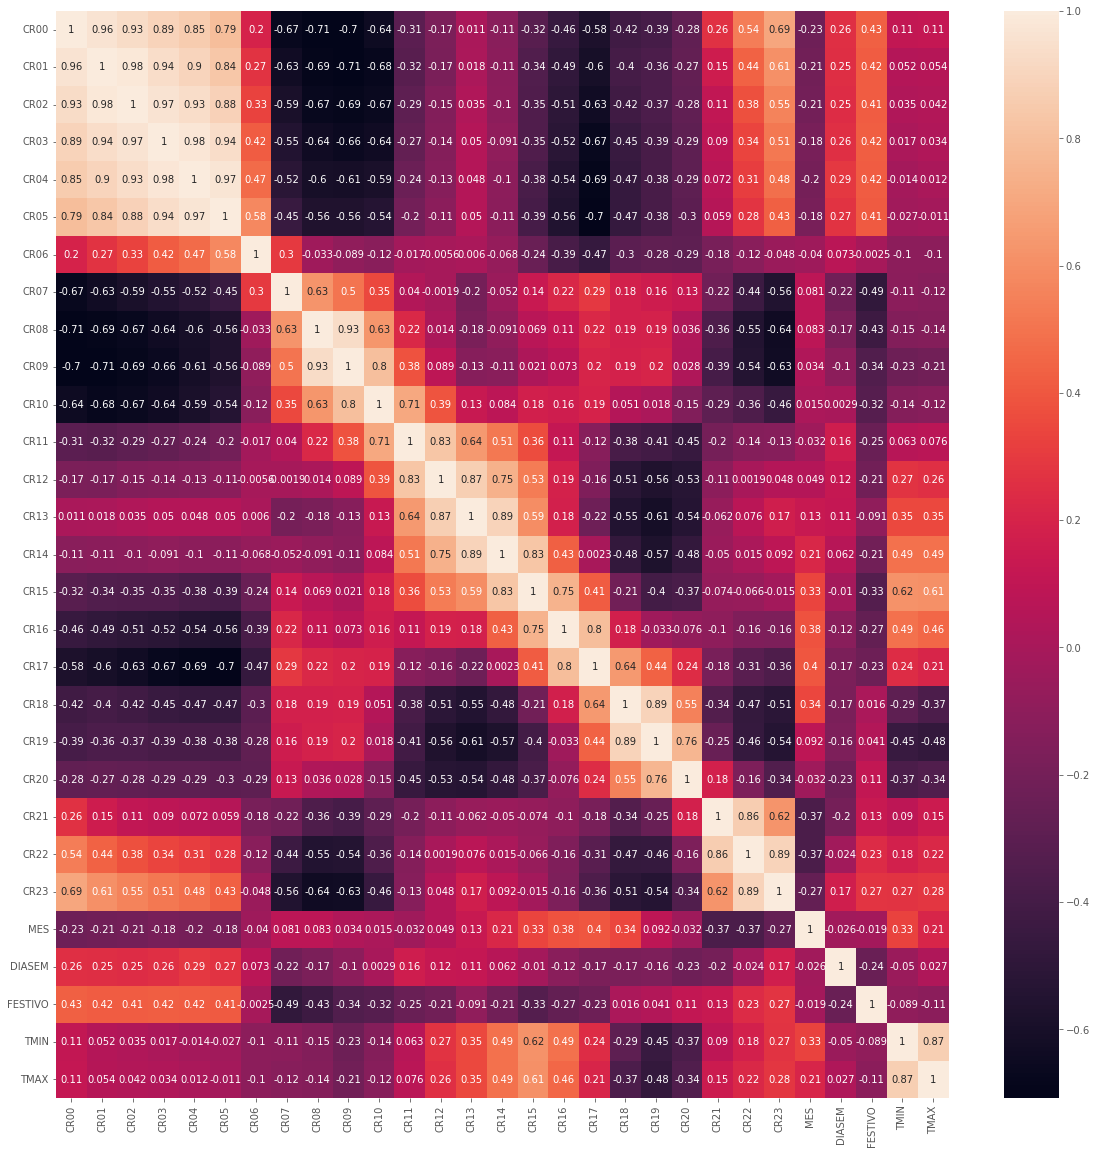

In [78]:
sub_sample_corr = df_aju_balanced.corr()
plt.figure(figsize=(20,20)) 
sns.heatmap(sub_sample_corr, annot=True) 

The correlation matrix shows the relationship between all variables presented in the data set. The correlation values range from -1 to 1, where -1 indicates a perfect inverse relationship, 0 indicates no correlation and 1 indicates a perfect direct relationship between two variables.

Looking at the correlation matrix, it can be seen that the variables CR00 to CR23 are, generally, and removing a few cases, correlated with each other (>0.3). It is interesting to note that the correlations between variables CR00 to CR05 are very high (> 0.8), indicating a very strong relationship between these variables.

Variables CR07 to CR20 have negative correlations with variables CR00 to CR06. Correlations are strongest for CR07 to CR11, indicating that these variables are inversely related to variables CR00 to CR06. Variables CR12 to CR23 have weaker correlations with variables CR00 to CR06, indicating that the relationship between these variables is weaker than the relationship between CR07 to CR11 and CR00 to CR06.

In addition to variables CR00 to CR23, three categorical variables are also presented: MONTH, DIASEM and HOLIDAY. These variables have positive correlations with CR23, as well as CR00 to CR03, indicating a direct relationship with these variables. There is also a positive correlation between DIASEM and FESTIVO. The variable TMIN has strong correlations with TMAX, as both are limiting temperatures. Temperatures also show a stronger correlation with month than with day of the week and holidays. This may be because factors such as the number of hours of sunlight, intensity of solar radiation, wind direction and humidity, among others, vary more significantly as the months progress, resulting in seasonal variation in temperatures.

In summary, the correlation matrix shows that variables CR00 to CR23 are correlated with each other, while the categorical variables are more weakly related to these variables. Variables CR07 to CR20 have an inverse relationship with variables CR00 to CR06, indicating that these variables may be important in predicting low values in variables CR00 to CR06.

In [79]:
corr = df_aju_balanced.corr() 
corr["FESTIVO"].sort_values() 

CR07      -0.486442
CR08      -0.429283
CR09      -0.344534
CR15      -0.327864
CR10      -0.323137
CR16      -0.267843
CR11      -0.245163
DIASEM    -0.243189
CR17      -0.233143
CR14      -0.209349
CR12      -0.207681
TMAX      -0.114096
CR13      -0.090868
TMIN      -0.089483
MES       -0.018780
CR06      -0.002543
CR18       0.016176
CR19       0.040598
CR20       0.112370
CR21       0.132420
CR22       0.234274
CR23       0.273758
CR05       0.411914
CR02       0.413678
CR04       0.417152
CR01       0.418786
CR03       0.423857
CR00       0.430382
FESTIVO    1.000000
Name: FESTIVO, dtype: float64

Regarding with the variable FESTIVO, which is the variable to be predicted, it can be seen that it is highly related to the numerical INPUT CR07, CR08, CR09, CR15, CR10, CR16, CR11 and the categorical DIASEM. This one makes sense, because holidays are related to what day of the week it is.    

In [80]:
df_aju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FECHA    2879 non-null   object 
 1   CR00     2879 non-null   float64
 2   CR01     2879 non-null   float64
 3   CR02     2879 non-null   float64
 4   CR03     2879 non-null   float64
 5   CR04     2879 non-null   float64
 6   CR05     2879 non-null   float64
 7   CR06     2879 non-null   float64
 8   CR07     2879 non-null   float64
 9   CR08     2879 non-null   float64
 10  CR09     2879 non-null   float64
 11  CR10     2879 non-null   float64
 12  CR11     2879 non-null   float64
 13  CR12     2879 non-null   float64
 14  CR13     2879 non-null   float64
 15  CR14     2879 non-null   float64
 16  CR15     2879 non-null   float64
 17  CR16     2879 non-null   float64
 18  CR17     2879 non-null   float64
 19  CR18     2879 non-null   float64
 20  CR19     2879 non-null   float64
 21  CR20     2879 

You can see that all variables have a correct data type, except DATE, but this variable will be deleted later, DIASEM and MES must be a categorical variable.

### 1.1.2 PREPARATION OF TRAINING AND TESTING SETS

The available fit data (df_aju) will be divided into two different sets (TR:80% and TS: 20%). TS should be used to validate the quality of the different models created.

In [81]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju['FESTIVO'] = df_aju['FESTIVO'].astype('category')
df_aju['DIASEM'] = df_aju['DIASEM'].astype('category')
df_aju['MES'] = df_aju['MES'].astype('category')

## Inputs of the model
INPUTS_NUM = df_aju.select_dtypes(include=['int64','float64']).columns.values.tolist()
INPUTS_CAT_1 =  df_aju.select_dtypes(include=['category']).columns.values.tolist()
INPUTS_CAT = [col for col in INPUTS_CAT_1 if col != 'FESTIVO' and col != 'FECHA']
print('Numerical inputs:', INPUTS_NUM)
print('Categorical inputs:', INPUTS_CAT)
INPUTS = INPUTS_NUM + INPUTS_CAT
OUTPUT = 'FESTIVO'

# Preprocess the variables when training the model
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())]) # Preprocess the variables when training the model 

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM),
        ('cat', categorical_transformer, INPUTS_CAT)
        ])

df_aju_enc = preprocessor.fit_transform(df_aju[INPUTS])
# Get the names of the encoded variables
INPUTS_CAT = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(INPUTS_CAT))
# Create a dataframe with the encoded variables
df_aju_enc = pd.DataFrame(df_aju_enc, columns=INPUTS_NUM + INPUTS_CAT)
INPUTS=[]
INPUTS = INPUTS_NUM + INPUTS_CAT


Numerical inputs: ['CR00', 'CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07', 'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16', 'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'TMIN', 'TMAX']
Categorical inputs: ['MES', 'DIASEM']


In [82]:
df_aju_enc

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,MES_9,MES_10,MES_11,MES_12,DIASEM_2,DIASEM_3,DIASEM_4,DIASEM_5,DIASEM_6,DIASEM_7
0,3.727852,2.841453,4.042316,3.352365,2.839118,2.469364,0.517895,-1.445556,-2.662598,-3.870338,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.626739,-0.655681,-1.079312,-1.092277,-0.995263,-0.957187,-0.756828,-0.361202,-0.082611,-0.060486,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.315452,-0.167275,-0.500701,-0.639632,-0.737586,-0.574072,-0.477338,-0.291955,-0.152907,0.549544,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.624176,0.121692,0.052673,-0.103923,-0.118600,-0.294884,-1.155142,-1.087826,-1.005001,-0.417915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.587723,0.724014,0.682056,0.669342,0.599374,0.566209,-0.616540,-1.172833,-1.268203,-0.976720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,-1.106556,-0.523049,-0.589757,-0.662710,-0.557566,-0.260852,0.369558,0.269266,0.355561,1.096483,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2875,-0.706214,-0.334066,-0.431392,-0.289792,-0.225242,0.146449,1.269436,0.552394,0.621646,1.082453,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2876,-0.299880,-0.129618,-0.046132,0.110845,0.106275,0.444091,0.977567,0.527995,0.721540,1.274271,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2877,-0.380957,-0.251496,-0.328086,-0.256529,-0.161877,0.233198,0.897827,0.619954,0.686520,0.945843,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Here we have already prepared the dataset containing the variables that we will use as INPUT. The following steps have been followed:
* First, the numerical and categorical variables that will be used as input to the model are identified. In addition, the variable DATE is eliminated, and the variable HOLIDAY is removed from the INPUTS as it will be the OUTPUT.
* Second, two transformers are defined: one to normalize the values of the numerical variables using StandardScaler (to improve the accuracy) and the other to encode the categorical variables using OneHotEncoder. Both transformers are combined in a ColumnTransformer, which will be in charge of applying the transformations corresponding to each type of variable.
* Third, the preprocessing is applied to the model input variables and a dataframe is created with the preprocessed variables. 

Finally, the list of input variables to be used in the model is updated with the preprocessed numerical and categorical variables.



#### 1.1.2.1 HOW TO SOLVE UNBALANCED DATASET
As can be seen, the output of the dataset is unbalanced due to the fact that the number of holidays in a year is much lower than the number of working days. Then the need arises to find a solution to this problem, for which two main solutions have been proposed. Oversampling before or after dividing the dataset into training and test. 

If oversampling is performed before the separation of training and test, part of the "synthetic" data generated to balance the loads will be both in the test and in the training set, which will result in perfect metrics in the test, as shown in the following image

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v8.png' style='width:200px;'/></td><td><img src='./images/v9.png' style='width:200px;'/></td></tr></table>

This is because it is being trained with the data that will later be used to test the model.

Therefore, it was decided to oversample after separating the data into training and test:

In [83]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
X = df_aju_enc[INPUTS]
y = df_aju[OUTPUT]
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

print('Shape of  X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)
print('Percentage of holidays in the training set: {0} %'.format(100*np.count_nonzero(y_train)/y_train.shape[0]))
print('Percentage of holidays in the test set: {0} %'.format(100*np.count_nonzero(y_test)/y_test.shape[0]))

Shape of  X_train: (2303, 43)
Shape of X_test: (576, 43)
Shape of y_train: (2303,)
Shape of y_test: (576,)
Percentage of holidays in the training set: 3.994789405123752 %
Percentage of holidays in the test set: 3.9930555555555554 %


It can be observed that the number of holidays is low.

In [84]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
y_train.value_counts()

0    2211
1      92
Name: FESTIVO, dtype: int64

In [85]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
y_test.value_counts()

0    553
1     23
Name: FESTIVO, dtype: int64

When applying oversampling in training, it must be taken into account that if a crossvalidation is performed, the dataset will be separated into two parts, one for validation and the other for training. This can lead to the problem shown in the following image:




<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v1.jpg' style='width:500px;'/></td><td><img src='./images/v2.jpg' style='width:500px;'/></td></tr></table>


 

As shown in the images above, the techniques for oversampling the dataset must be applied after separating the data for cross validation, otherwise the training dataset would be influenced, causing a data leakage problem, or in other words, there is a risk of having trained the model with the dataset to be used for validation. Therefore, SMOTE will be used, an oversampling technique that will be applied later to the crossvalidation.

---
## 1.2. FITTING A SIMPLE DECISION TREE

This model can serve as a reference and comparison with other more complex models.


### 1.2.1 ALL VARIABLES MODEL

First, a model with all the variables will be made to check which are the most important variables. From this model, by performing a grid_search, the hyperparameters that maximize the balanced_accuracy will be chosen. The hyperparameters chosen are:
* min_impurity_decrease: minimum impurity reduction that a node has to produce to keep cutting.
* min_samples_leaf: minimum number of samples that a leaf must contain.
* min_samples_split: minimum number of samples a node has to have to split.

During the training of the model of all the variables, besides looking for which variables are essential for the optimal performance of the model, two variations of the model will be treated, in order to see how the balancing of the output affects the results, and which is the correct way to balance, or rather, to apply the balancing techniques.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v6.png' style='width:200px;'/></td><td><img src='./images/v7.png' style='width:200px;'/></td></tr></table>

First, the training has been performed without balancing the output, obtaining the above confusion matrix.  It is observed that the model is quite bad, the sensitivity in the test is 0.35 and although the unbalanced accuracy is good, it is not real, since having the dataset so unbalanced you will always have a good accuracy even if our model predicts that all days are not holidays.  With this, it is easy to visualize the need for data balancing techniques. In this case SMOTE will be used, as mentioned above, and the following results will be obtained

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v4.png' style='width:200px;'/></td><td><img src='./images/v5.png' style='width:200px;'/></td></tr></table>

It can be observed that after using the SMOTE oversampling technique, better results are obtained, raising the sensitivity up to 0.7 and obtaining a balanced accuracy of 0.84 in the test data set. 

Then, using the SMOTE model, the most important variables for the decision tree model are the following:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v3.png' style='width:1000px;'/></td></tr></table>

The variables to be chosen are: CR7, CR8, CR15, DIASEM_6, DIASEM_7.


### 1.2.2 FINAL MODEL

In order to make the model more consistent, the most important variables that the previous model had chosen, are chosen:

In [86]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
smote = SMOTE(sampling_strategy='minority', random_state=0)

INPUTS_DT_DEF = ['CR07','CR08','CR15','DIASEM_6','DIASEM_7']

# Define the pipeline with preprocessing, SMOTE and decision tree classifier
pipe = ImbPipeline(steps=[
    ('smote', smote),
    ('DT', DecisionTreeClassifier(criterion='gini', random_state=0))
])

# Define the grid search parameters as before
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005),
         'DT__min_samples_leaf': np.arange(1,10,1),
         'DT__min_samples_split':  np.arange(2,10,1)}

# Use GridSearchCV from sklearn with the imbalanced pipeline
nFolds = 10
tree_fit_def = GridSearchCV(estimator=pipe,
                        param_grid=param,
                        n_jobs=-1,
                        scoring='balanced_accuracy',
                        cv=nFolds)

# Fit the model with X_train and y_train as before
tree_fit_def.fit(X_train[INPUTS_DT_DEF], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=0,
                                              sampling_strategy='minority')),
                                       ('DT',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='balanced_accuracy')

A grid_search is used to search for the most important parameters in the decision tree. As can be seen, the hyperparameters chosen are:
* min_impurity_decrease: 0.01
* min_samples_leaf: 1
* min_samples_split: 2

In [87]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
tree_fit_def.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

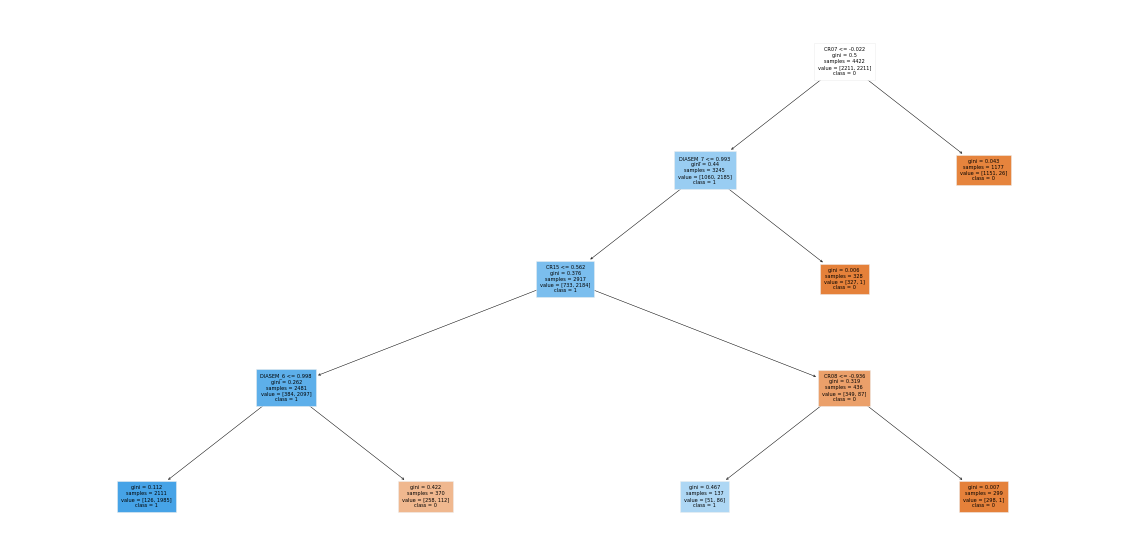

In [88]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit_def.best_estimator_['DT'],
          feature_names= INPUTS_DT_DEF,
          class_names= [str(s) for s in y_train.unique()],
          fontsize=5, filled=True)
plt.show()

In [89]:
#Get number of nodes
tree_fit_def.best_estimator_['DT'].tree_.node_count

11

Also, it is important to see how our tree behaves, so the tree has been visualized to see the cuts it performs. As can be seen, the main hyperparameter that is controlling the number of cuts is the minimum decrease of impurity.

In [90]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# model predictions in training (TR) and test (TS) sets
clf = tree_fit_def.best_estimator_['DT']
y_train_pred = clf.predict(X_train[INPUTS_DT_DEF]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_DT_DEF]).tolist()
Train1=X_train.copy()
Train1=pd.concat([Train1, y_train], axis=1)
Test1=X_test.copy()
Test1=pd.concat([Test1, y_test], axis=1)
Train1['DT']=y_train_pred
Test1['DT']=y_test_pred

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])

                         TR        TS
Accuracy           0.918802  0.907986
Balanced accuracy  0.905625  0.847905

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0   1
         0 2034 177
         1   10  82

Accuracy: 0.92
No Information Rate: 0.86
P-Value [Acc > NIR]: 1.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.89
Specificity: 0.92
Precision: 1.0
Recall: 0.92
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.11
Balanced accuracy: 0.91
F1 Score: 0.96
Positive label: 0


In [91]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 505 48
         1   5 18

Accuracy: 0.91
No Information Rate: 0.85
P-Value [Acc > NIR]: 1.0
Kappa: 0.37
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.78
Specificity: 0.91
Precision: 0.99
Recall: 0.91
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.11
Balanced accuracy: 0.85
F1 Score: 0.95
Positive label: 0


As can be seen in the test and training models, the accuracy is more or less identical to the model with all parameters and the sensitivity parameter is of the same order as the previous model, but the model is more consistent.

---
## 1.3.FITTING A SIMPLE DECISION TREE


When it comes to optimising and defining the best model for each case, the same methodology will always be followed, with some additional steps if necessary:

1. First, a gridsearch will be carried out with all the variables, to see which of them are most important and thus eliminate them from our model.

2. Afterwards, we will do another gridsearch, where we will choose the best hyperparameters for the definitive variables.

3. Finally, we will represent a tree with the variables and the optimal hyperparameters.

As mentioned above, we will start by making a general model with all the variables.


### 1.3.1 ALL VARIABLES MODEL

For this model, a gridsearch has been performed with a range of 'BT__n_estimators' from 10 to 150 in steps of 5 for the model of all variables. In addition to marking which variables are essential to the model, the results of the accuracy, balanced accuracy and confusion matrix, along with other metrics, will be displayed and then compared with the model of the important variables to see how much it has worsened or improved.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/dag_accuracies_bagged_ori.png' style='width:200px;'/></td></tr></table>

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/dag_training_bagged_ori.png' style='width:200px;'/></td><td><img src='./images/dag_test_bagged_ori.png' style='width:200px;'/></td></tr></table>

The importance of the different variables in THIS model will now be shown:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/dag_important_var_bagged_ori.png' style='width:700px;'/></td></tr></table>

As can be seen, variables CR07, CR08, CR15, DIASEM_7 and DIASEM_6 are the most important variables for the model, and the ones that are certain to be in the final model.

### 1.3.2 FINAL MODEL

We started with an INPUT_BT=['CR07', 'DIASEM_7', 'DIASEM_6', 'CR15', 'CR08'], but by adding the following variables, which had a slight importance in the upper graph, MES_12, MES_6, CR20 and CR19, we have managed to improve all the metrics:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/dag_accuracies_bagged_var5.png' style='width:200px;'/></td><td><img src='./images/dag_accuracies_bagged_var9.png' style='width:200px;'/></td></tr></table>

<table><tr><td><img src='./images/dag_test_bagged_var5.png' style='width:200px;'/></td><td><img src='./images/dag_test_bagged_var9.png' style='width:200px;'/></td></tr></table>

As can be seen, the one on the right, which is the model with the inputs CR07, 'DIASEM_7, DIASEM_6, CR15, CR08, MES_12, MES_6, CR20, CR19 gives better results in all the metrics than if we remove those 4 inputs, therefore they will be maintained. Moreover, it is seen that it shows a similar behaviour to the model for all variables:

<table><tr><td><img src='./images/dag_accuracies_bagged_ori.png' style='width:200px;'/></td><td><img src='./images/dag_accuracies_bagged_var9.png' style='width:200px;'/></td></tr></table>

<table><tr><td><img src='./images/dag_test_bagged_ori.png' style='width:200px;'/></td><td><img src='./images/dag_test_bagged_var9.png' style='width:200px;'/></td></tr></table>

The one on the right is the model with the important variables and the one on the left is the model with all variables. Both have a similar behaviour, the first one being more robust. We will now show the gridsearch code to obtain the best hyperparameters with the final variables:

In [92]:
INPUTS_BT = ['CR07', 'DIASEM_7', 'DIASEM_6', 'CR15', 'CR08','MES_12','MES_6','CR20','CR19']
print(INPUTS_BT)

['CR07', 'DIASEM_7', 'DIASEM_6', 'CR15', 'CR08', 'MES_12', 'MES_6', 'CR20', 'CR19']


In [93]:
smote = SMOTE(sampling_strategy='minority', random_state=0)


param = {'BT__n_estimators': range(10, 150, 5)} # Number of trees to aggregate

base_estimator =  ImbPipeline(steps=[('smote', smote),
                                    ('DT', DecisionTreeClassifier(criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=0))])


pipe =  Pipeline(steps=[('BT', 
                            BaggingClassifier(base_estimator=base_estimator,
                                              random_state=0))])


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit_novar = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='balanced_accuracy', # balanced_accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
bt_fit_novar.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingClassifier(base_estimator=Pipeline(steps=[('smote',
                                                                                          SMOTE(random_state=0,
                                                                                                sampling_strategy='minority')),
                                                                                         ('DT',
                                                                                          DecisionTreeClassifier(random_state=0))]),
                                                          random_state=0))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(10, 150, 5)},
             scoring='balanced_accuracy')

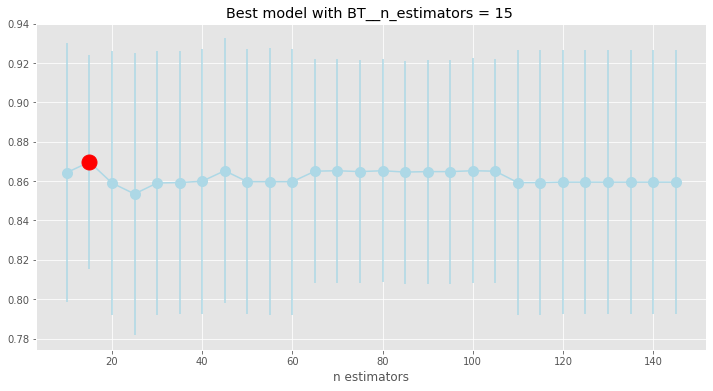

In [94]:
MT.plotModelGridError(bt_fit_novar)

As can be seen, 15 trees are the optimum, and they are also a low number, which ensures that the model will be robust

In [95]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# model predictions in training (TR) and test (TS) sets
clf = bt_fit_novar
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], 
                      index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])

                         TR        TS
Accuracy           0.999132  0.973958
Balanced accuracy  0.989130  0.840593

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0  1
         0 2211  0
         1    2 90

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 0.5
Sensitivity: 0.98
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.04
Balanced accuracy: 0.99
F1 Score: 1.0
Positive label: 0


In [96]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 545  8
         1   7 16

Accuracy: 0.97
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.05
Kappa: 0.67
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.7
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.04
Balanced accuracy: 0.84
F1 Score: 0.99
Positive label: 0


### 1.3.3 FINAL MODEL WITHOUT GRIDSEARCH
Now, having chosen the hyperparameters and variables, the final model will be assembled.


In [97]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
number_estimators = 15
INPUTS_BT = ['CR07', 'DIASEM_7', 'DIASEM_6', 'CR15', 'CR08','MES_12','MES_6','CR20','CR19']
base_estimator =  ImbPipeline(steps=[('smote', smote),
                                  ('DT', DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=0))]) # For replication

bag_def = BaggingClassifier(base_estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=0)
                     
# fit the bagged trees               
bag_def.fit(X_train[INPUTS_BT], y_train)

BaggingClassifier(base_estimator=Pipeline(steps=[('smote',
                                                  SMOTE(random_state=0,
                                                        sampling_strategy='minority')),
                                                 ('DT',
                                                  DecisionTreeClassifier(random_state=0))]),
                  n_estimators=15, random_state=0)

In [98]:
# model predictions in training (TR) and test (TS) sets
clf = bag_def
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()
Train1['BG']=y_train_pred
Test1['BG']=y_test_pred

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], 
                      index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc) # Accuracy and balanced accuracy

                         TR        TS
Accuracy           0.999132  0.973958
Balanced accuracy  0.989130  0.840593


There does not seem to be any overfitting, as there is not much difference between the two.

In [99]:
print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])


METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0  1
         0 2211  0
         1    2 90

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 0.5
Sensitivity: 0.98
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.04
Balanced accuracy: 0.99
F1 Score: 1.0
Positive label: 0


In [100]:
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 545  8
         1   7 16

Accuracy: 0.97
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.05
Kappa: 0.67
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.7
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.04
Balanced accuracy: 0.84
F1 Score: 0.99
Positive label: 0


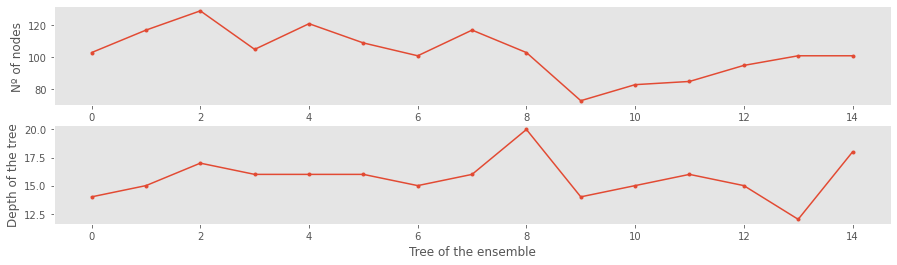

In [101]:
# number of nodes in each tree of the ensemble
node_count_trees = [t['DT'].tree_.node_count for t in bag_def.estimators_]

# number of nodes in each tree of the ensemble
depth_trees = [t['DT'].tree_.max_depth for t in bag_def.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees, '.-')
plt.ylabel('Nº of nodes')                       
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

The trees have a similar depth, moving mostly around 15-20 in depth. The number of nodes also stays around 100, except for 2 and 9, which have 120 and 80 nodes respectively. For bagged trees, you are interested in deep trees that learn the model very well, so being deep and with enough nodes is consistent.

#### 1.3.3.1 TREES VOTE

In [102]:
clf = bag_def
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
y_train_pred_trees = list([t['DT'].predict(X_train[INPUTS_BT]) for t in bag_def.estimators_])

dfouts = pd.DataFrame(y_train_pred_trees)
dfouts.head()

y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()
y_test_pred_trees = list([t['DT'].predict(X_test[INPUTS_BT]) for t in bag_def.estimators_])

dfouts_tr = pd.DataFrame(y_train_pred_trees)
dfouts_tr.head()
dfouts_ts = pd.DataFrame(y_test_pred_trees)
dfouts_ts.head()

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


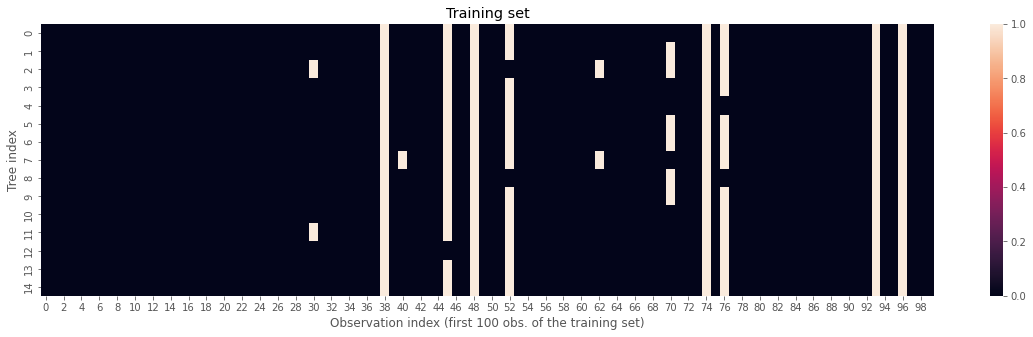

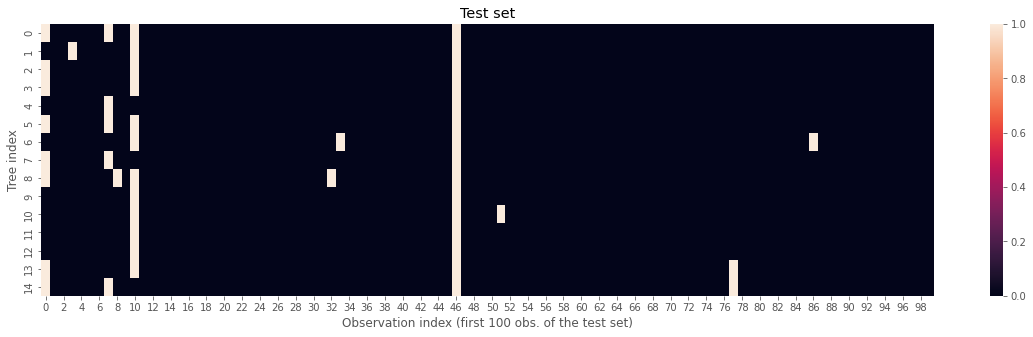

In [103]:
# plot the votes of each tree for the first 100 observations of the training set
fig = plt.figure(figsize=(20, 5))
sns.heatmap(dfouts_tr.iloc[:,:100])
plt.xlabel('Observation index (first 100 obs. of the training set)')
plt.ylabel('Tree index')
plt.title('Training set')                                 
plt.show()

fig = plt.figure(figsize=(20, 5))
sns.heatmap(dfouts_ts.iloc[:,:100])
plt.xlabel('Observation index (first 100 obs. of the test set)')
plt.ylabel('Tree index')
plt.title('Test set')                                 
plt.show()

It can be seen that the trees tend to be unanimous in the voting, with some of them and in a few cases, such as 0, 7 and 10, showing a generally good performance.

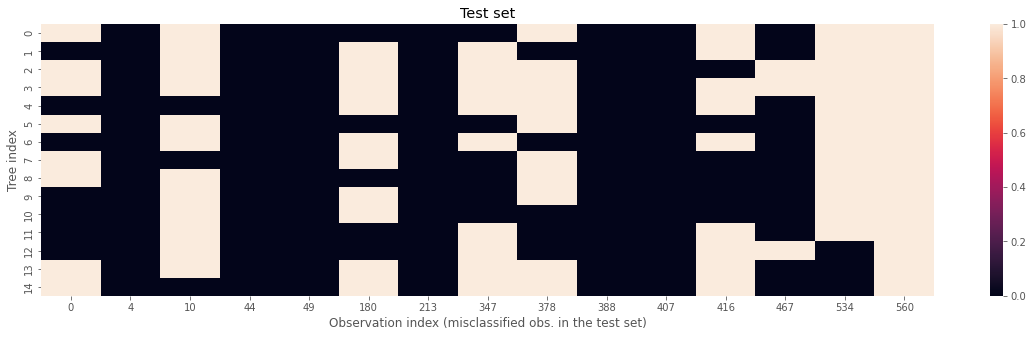

In [104]:
# focus on the misclassified observations
y_train_pred = clf.predict(X_train[INPUTS_BT]).tolist()
class_errors_tr = [x!=y for x,y in zip(y_train.tolist(), y_train_pred)]

y_test_pred = clf.predict(X_test[INPUTS_BT]).tolist()
class_errors_ts = [x!=y for x,y in zip(y_test.tolist(), y_test_pred)]

# plot the votes of each tree for the first 100 observations of the training set
fig = plt.figure(1,figsize=(20, 5))
sns.heatmap(dfouts_ts.iloc[:,class_errors_ts]) 
plt.xlabel('Observation index (misclassified obs. in the test set)')
plt.ylabel('Tree index')
plt.title('Test set')                                 
plt.show()

The cases of 4, 44, 49, 213, 388, 407 and 560 stand out, where in no case did any of the trees vote for the correct answer.


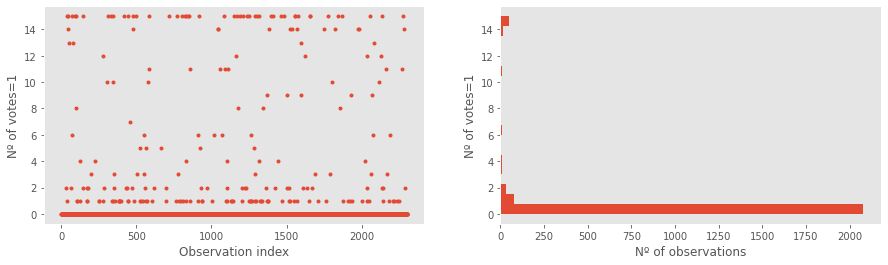

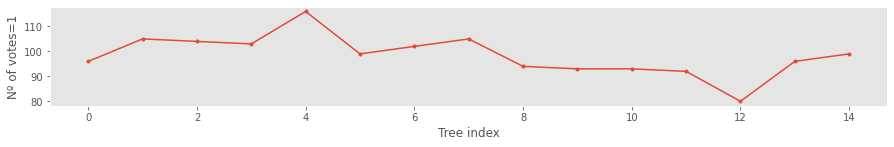

In [105]:
#number of votes = 1 for each observation
n_1s_each_obs = dfouts.sum(axis=0)

# number of ones for each tree
n_1s_each_tree = dfouts.sum(axis=1)

# plot
fig = plt.figure(figsize=(15, 4))
ax1=plt.subplot(1,2,1)
plt.plot(n_1s_each_obs, '.')
plt.ylabel('Nº of votes=1')
plt.xlabel('Observation index')                       
plt.grid()

plt.subplot(1,2,2,sharey=ax1)
plt.hist(n_1s_each_obs,bins=20,orientation='horizontal')
plt.ylabel('Nº of votes=1')
plt.xlabel('Nº of observations')
plt.grid()
plt.show()

fig = plt.figure(figsize=(15, 4))
plt.subplot(2,1,2)
plt.plot(n_1s_each_tree, '.-')
plt.ylabel('Nº of votes=1')                       
plt.xlabel('Tree index')                  
plt.grid()
plt.show()

It can be observed that the most of trees vote class 0. This is because class 0 is the majority class in the data set.
Moreover, the votes are concentrated at the extremes, which indicates that for most of the cases there is unanimity in the votes.
On the other hand, the lower graph is also interesting, where it can be seen that all the trees vote the same number of times for class 1, moving around 100 votes, except in the case of 4 and 12, where there are two peaks of 110 and 80.


---

## 1.4. FITTING A RANDOM FOREST

### 1.4.1 ALL VARIABLES MODEL

Following the same structure as with bagging trees, we will first start by doing a gridsearch and then choose from the model of all the variables, the variables that are considered essential for optimal performance.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/jac_accuracies_random_ori.png' style='width:200px;'/></td></tr></table>

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/jac_training_random_ori.png' style='width:200px;'/></td><td><img src='./images/jac_test_random_ori.png' style='width:200px;'/></td></tr></table>

Ahora se mostrará la importancia de las distintas variables en el modelo:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/jac_important_random.png' style='width:700px;'/></td></tr></table>

The variables that are important, and will safely be in the model of the important variables, are the following: CR04, CR07, CR08, CR14, CR15, CR17, CR18, CR19, CR20, TMAX, MES_6, MES_7, MES_12, DIASEM_6, DIASEM_7.

### 1.4.2 MODELO CON VARIABLES IMPORTANTES

In [106]:
# find optim nº of trees in the ensemble and max_features
smote = SMOTE(sampling_strategy='minority', random_state=0)

param = {'RF__max_features': range(7, 13, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 100, 5)} # Number of trees in the forest

base_estimator_rf =ImbPipeline(steps=[('smote', smote),
                                    ('RF', RandomForestClassifier(
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                                    )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=base_estimator_rf, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='balanced_accuracy', 
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_RF = ['CR07','CR04','CR08','CR14','CR15','CR17','CR18','CR19','CR20', 
             'TMAX','MES_6','MES_7'
             ,'MES_12','DIASEM_6','DIASEM_7']   
rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=0,
                                              sampling_strategy='minority')),
                                       ('RF',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(7, 13),
                         'RF__n_estimators': range(20, 100, 5)},
             scoring='balanced_accuracy')

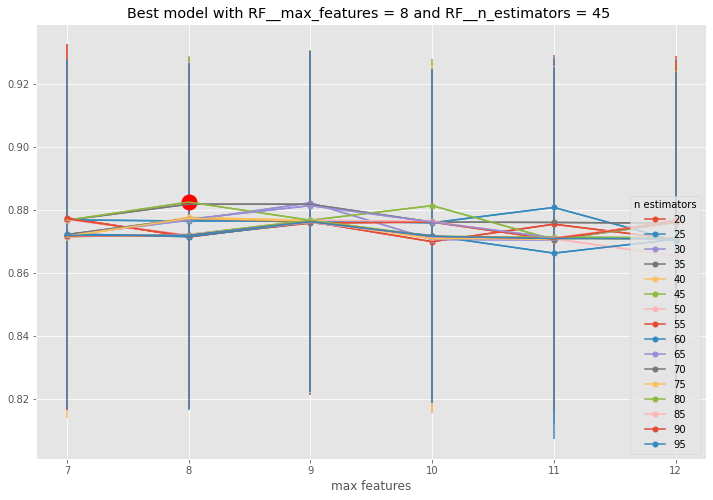

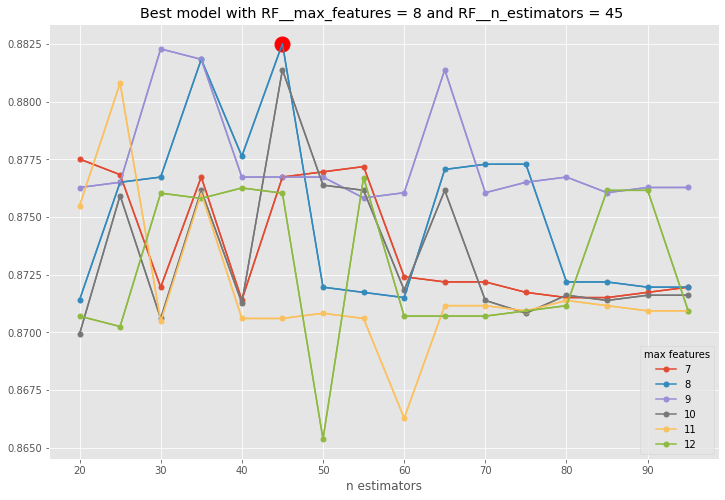

In [107]:
MT.plotModelGridError(rf_fit)

The gridsearch results indicate that the best performing model is the one with the following hyperparameters:
* RF__n_estimators(Number of trees) = 45
* RF__max_features = 8

In [108]:
# model predictions in training (TR) and test (TS) sets
clf = rf_fit
y_train_pred = clf.predict(X_train[INPUTS_RF]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_RF]).tolist()

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], 
                      index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])

                    TR        TS
Accuracy           1.0  0.982639
Balanced accuracy  1.0  0.845114

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0  1
         0 2211  0
         1    0 92

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.04
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 0


In [109]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 550  3
         1   7 16

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.34
Sensitivity: 0.7
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.03
Balanced accuracy: 0.85
F1 Score: 0.99
Positive label: 0


### 1.3.3 FINAL MODEL
Now, having chosen the hyperparameters and variables, the final model will be assembled.

In [110]:
number_estimators =45
max_features=8

rf_def =ImbPipeline(steps=[('smote', smote),
                                ('RF',RandomForestClassifier(n_estimators=number_estimators,
                                        max_features=max_features,
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0))])
                     
# fit the bagged trees
INPUTS_RF = ['CR07','CR04','CR08','CR14','CR15','CR17','CR18','CR19','CR20', 
             'TMAX','MES_6','MES_7',
             'MES_12','DIASEM_6','DIASEM_7'] 
rf_def.fit(X_train[INPUTS_RF], y_train)

Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy='minority')),
                ('RF',
                 RandomForestClassifier(max_features=8, n_estimators=45,
                                        random_state=0))])

In [111]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# model predictions in training (TR) and test (TS) sets
clf = rf_def
y_train_pred = clf.predict(X_train[INPUTS_RF]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_RF]).tolist()
Train1['RF']=y_train_pred
Test1['RF']=y_test_pred

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], 
                      index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])

                    TR        TS
Accuracy           1.0  0.982639
Balanced accuracy  1.0  0.845114

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0  1
         0 2211  0
         1    0 92

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.04
Balanced accuracy: 1.0
F1 Score: 1.0
Positive label: 0


In [112]:
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 550  3
         1   7 16

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.34
Sensitivity: 0.7
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.03
Balanced accuracy: 0.85
F1 Score: 0.99
Positive label: 0


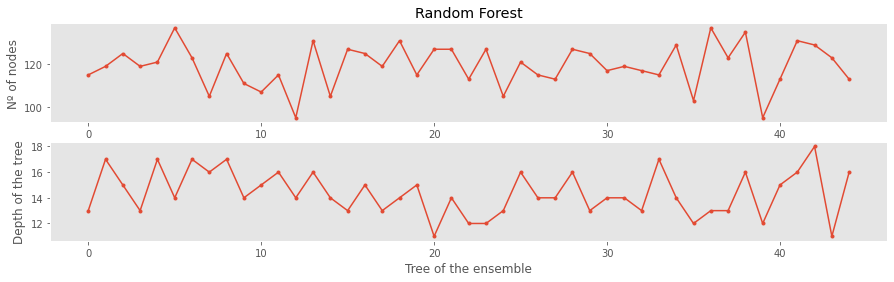

In [113]:
# number of nodes in each tree of the forest

RF_class_estim = rf_def.named_steps['RF']
node_count_trees_rf = [t.tree_.node_count for t in RF_class_estim.estimators_]


# number of nodes in each tree of the ensemble
depth_trees_rf = [t.tree_.max_depth for t in RF_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees_rf, '.-')
plt.ylabel('Nº of nodes')     
plt.title('Random Forest')                  
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees_rf, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

As with bagged tree, the trees have a similar depth, mostly having around 12-18 in depth. In most trees, the number of nodes remains around 120.

---
## 1.5. FITTING GRADIENT BOOSTING


### 1.5.1 ALL VARIABLES MODEL

For this model, a gridsearch has been performed with a range of 'GB__n_estimators' from 100 to 2000 trees in steps of 100 for the model of all variables. In this model we have chosen a learning_rate of 0.1 for each tree and a depth of 2. In addition to selecting which variables are essential for the model, we will show the results of accuracy, balanced accuracy and the confusion matrix, along with other metrics, to later compare it with the model of the important variables and see how much it has worsened or improved. The image below shows the number of trees that maximise the balanced_accuracy score.
<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v13.png' style='width:500px;'/></td></tr></table>

With this model, we have the following confusion matrixes:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v14.png' style='width:200px;'/></td><td><img src='./images/v15.png' style='width:200px;'/></td></tr></table>

In addition, the most important variables with this model are:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v12.png' style='width:1000px;'/></td></tr></table>


### 1.5.2 FINAL MODEL

In order to have a more solid model, the most important variables will be chosen, in this case, the following variables will be chosen 
CR05, CR07, CR08, CR14, CR15, CR17, CR18, CR20, DIASEM_6, DIASEM_7. In addition, we have chosen to create a weak tree of depth 2 because the metrics come out better.


In [114]:
# find optim nº of trees in the ensemble and max_features
learning_rate = 0.1
smote = SMOTE(sampling_strategy='minority', random_state=0)
max_depth = 2

param = {'GB__n_estimators': range(100, 2000, 100), # Number number of 
         #'GB__max_depth': range(1, 2, 1)} # Number of trees in the forest}
}
base_estimator_gb =ImbPipeline(steps=[('smote', smote),
                                    ('GB', GradientBoostingClassifier(
                                            learning_rate = learning_rate,
                                            max_features = 1.0, # 'auto', ‘sqrt’, ‘log2’, int or float, default=None
                                            loss = 'exponential',
                                            max_depth = max_depth,   # binomial and multinomial deviance
                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                            min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                            random_state=0)
                                    )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
gb_fit = GridSearchCV(estimator=base_estimator_gb, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='balanced_accuracy', # Metric to optimize
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_GB = ['CR05','CR07','CR08','CR14','CR15','CR17','CR18','CR20','DIASEM_6','DIASEM_7', 'TMAX'] 
gb_fit.fit(X_train[INPUTS_GB], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=0,
                                              sampling_strategy='minority')),
                                       ('GB',
                                        GradientBoostingClassifier(loss='exponential',
                                                                   max_depth=2,
                                                                   max_features=1.0,
                                                                   random_state=0))]),
             n_jobs=-1, param_grid={'GB__n_estimators': range(100, 2000, 100)},
             scoring='balanced_accuracy')

In the graph below, we can see that the best model is with 1200 trees, but as we are looking for a more robust model, and the error is practically constant up to 400 trees, we are going to choose 400 trees as GB__n_estimators in the final model.


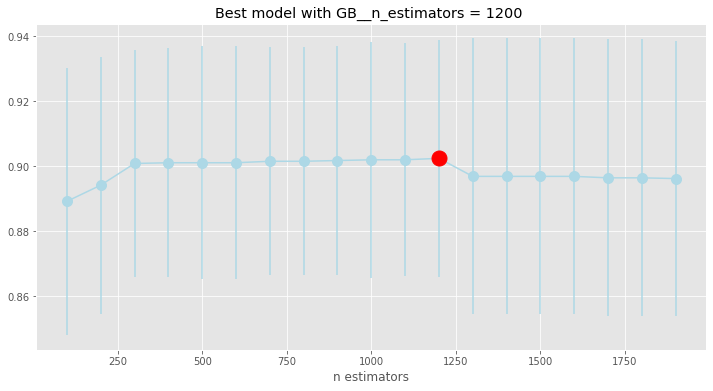

In [115]:
MT.plotModelGridError(gb_fit)

### 1.5.3 FINAL MODEL WITHOUT GRIDSEARCH

In [116]:
INPUTS_GB = ['CR05','CR07','CR08','CR14','CR15','CR17','CR18','CR20','DIASEM_6','DIASEM_7', 'TMAX'] 
number_estimators = 400
learning_rate = 0.1
smote = SMOTE(sampling_strategy='minority', random_state=0)
max_depth = 2

gb_fit_def =ImbPipeline(steps=[('smote', smote),
                                    ('GB', GradientBoostingClassifier(
                                    n_estimators = number_estimators,
                                    learning_rate = learning_rate,
                                    max_features = 1.0, # 'auto', ‘sqrt’, ‘log2’, int or float, default=None
                                    loss = 'exponential',
                                    max_depth = max_depth,   # binomial and multinomial deviance
                                    min_samples_split=2, # Minimum number of obs in node to keep cutting
                                    min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                    random_state=0)
                                    )])

gb_fit_def.fit(X_train[INPUTS_GB], y_train)

Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy='minority')),
                ('GB',
                 GradientBoostingClassifier(loss='exponential', max_depth=2,
                                            max_features=1.0, n_estimators=400,
                                            random_state=0))])

Se va a representar un árbol débil como ejemplo.

In [117]:
tree = gb_fit_def.named_steps['GB'].estimators_[0,0]

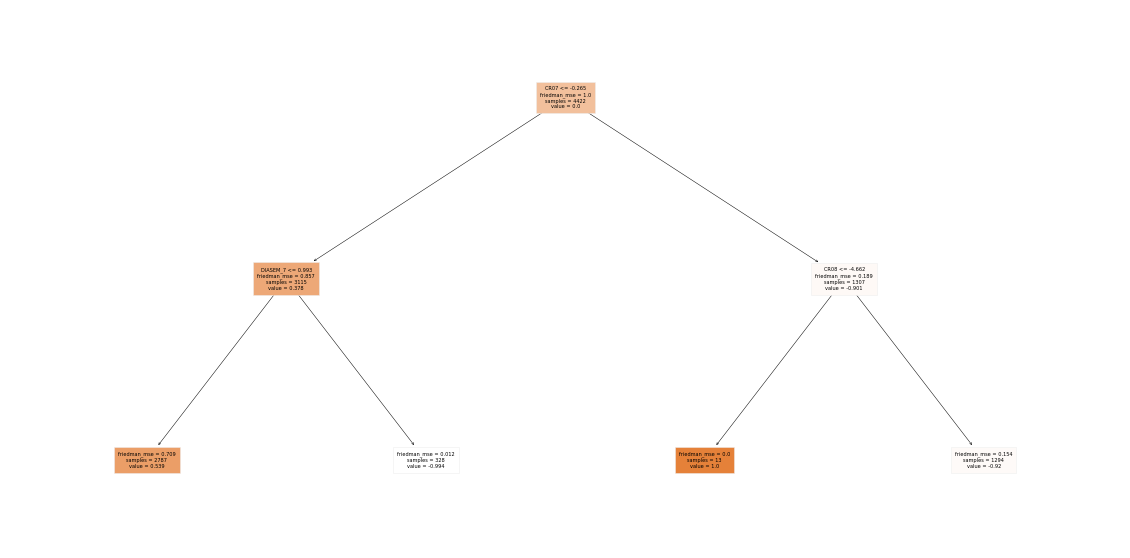

In [118]:
plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names= INPUTS_GB,
          class_names= [str(s) for s in y_train.unique()],
          fontsize=5, filled=True)
plt.show()


In [119]:
# model predictions in training (TR) and test (TS) sets
#GB_class_estim=gb_fit
clf = gb_fit_def
y_train_pred = clf.predict(X_train[INPUTS_GB]).tolist()
y_test_pred = clf.predict(X_test[INPUTS_GB]).tolist()
Train1['GB']=y_train_pred
Test1['GB']=y_test_pred

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], index= ['Accuracy', 'Balanced accuracy'],  
                      columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])

                         TR        TS
Accuracy           0.998263  0.979167
Balanced accuracy  0.988678  0.843305

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0  1
         0 2209  2
         1    2 90

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.98
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.98
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.04
Balanced accuracy: 0.99
F1 Score: 1.0
Positive label: 0


In [120]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 548  5
         1   7 16

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.01
Kappa: 0.72
Mcnemar's Test P-Value: 0.77
Sensitivity: 0.7
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.04
Balanced accuracy: 0.84
F1 Score: 0.99
Positive label: 0


If the confusion matrixes are compared, it can be observed that it has more or less the same accuracy, the sensitivity is similar and therefore we have a more robust model with the same metrics.


---
## 1.6. STACKING MODEL 
We will use the best three models to try to improve the solutions obtained.


In [121]:
#------SMOTE------
smote = SMOTE(sampling_strategy='minority', random_state=0)

#------------------------------------------- bagging tree best model-------------------------------------------
number_estimators = 15

estimator_bg =  ImbPipeline(steps=[('smote', smote),
                                  ('DT', DecisionTreeClassifier( criterion='gini',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=0))]) # For replication

base_estimator_bg_best  = BaggingClassifier(base_estimator=estimator_bg,
                                    n_estimators=number_estimators,
                                    random_state=0)

#-------------------------------------------gradient boosting best model-------------------------------------------
number_estimators = 400
learning_rate = 0.1
max_depth = 2

base_estimator_gb_best =ImbPipeline(steps=[('smote', smote),
                                    ('GB', GradientBoostingClassifier(
                                    n_estimators = number_estimators,
                                    learning_rate = learning_rate,
                                    max_features = 1.0, # 'auto', ‘sqrt’, ‘log2’, int or float, default=None
                                    loss = 'exponential',
                                    max_depth = max_depth,   # binomial and multinomial deviance
                                    min_samples_split=2, # Minimum number of obs in node to keep cutting
                                    min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                    random_state=0)
                                    )])
#-------------------------------------------random fores best model-------------------------------------------

number_estimators =45
max_features=8

base_estimator_rf_best =ImbPipeline(steps=[('smote', smote),
                                ('RF',RandomForestClassifier(n_estimators=number_estimators,
                                        max_features=max_features,
                                        criterion='gini',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0))])

#-------------------------------------------Estimators-------------------------------------------
from sklearn.ensemble import VotingClassifier

estimators_best = [
     ('rforest', base_estimator_rf_best),
     ('bg', base_estimator_bg_best ),
     ('gboost', base_estimator_gb_best )]

#gridearch con votingclassifier con los pesos
weights = [0.1, 0.3, 0.6]
stacked_cl = VotingClassifier(estimators = estimators_best, weights = weights) #Votacion es la media
stacked_cl = stacked_cl.fit(X_train, y_train)
stacked_cl.get_params()

{'estimators': [('rforest',
   Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy='minority')),
                   ('RF',
                    RandomForestClassifier(max_features=8, n_estimators=45,
                                           random_state=0))])),
  ('bg',
   BaggingClassifier(base_estimator=Pipeline(steps=[('smote',
                                                     SMOTE(random_state=0,
                                                           sampling_strategy='minority')),
                                                    ('DT',
                                                     DecisionTreeClassifier(random_state=0))]),
                     n_estimators=15, random_state=0)),
  ('gboost',
   Pipeline(steps=[('smote', SMOTE(random_state=0, sampling_strategy='minority')),
                   ('GB',
                    GradientBoostingClassifier(loss='exponential', max_depth=2,
                                               max_features=1.0, n_estima

In [122]:
# model predictions in training (TR) and test (TS) sets
clf = stacked_cl
y_train_pred = clf.predict(X_train[INPUTS]).tolist()
y_test_pred = clf.predict(X_test[INPUTS]).tolist()
Train1['STC']=y_train_pred
Test1['STC']=y_test_pred

# main metrics
acc_tr = metrics.accuracy_score(y_train,y_train_pred)
acc_ts = metrics.accuracy_score(y_test,y_test_pred)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], 
                      index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train, y_train_pred, labels=[0,1])

                         TR        TS
Accuracy           0.999566  0.984375
Balanced accuracy  0.994565  0.846018

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0  1
         0 2211  0
         1    1 91

Accuracy: 1.0
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.99
Specificity: 1.0
Precision: 1.0
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.04
Detection prevalence: 0.04
Balanced accuracy: 0.99
F1 Score: 1.0
Positive label: 0


In [123]:
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test, y_test_pred, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 551  2
         1   7 16

Accuracy: 0.98
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.77
Mcnemar's Test P-Value: 0.18
Sensitivity: 0.7
Specificity: 1.0
Precision: 0.99
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.03
Balanced accuracy: 0.85
F1 Score: 0.99
Positive label: 0


As can be seen, a slightly higher balanced accuracy is obtained in the test than the component models.

---
## 1.7. CREATION OF A SMALL NUMBER OF VARIABLES CONTAINING THE INFORMATION COLLECTED IN THE VARIABLES CR00 TO CR23- AND CREATE A SIMPLE TREE BASED ON THESE VARIABLES.
- The set of variables created has to be a linear combination of CR00, ..., CR23.

For this section, a Principal Component Analysis (PCA) will be performed. PCA is a dimensionality reduction technique used to reduce the number of variables in a data set while maintaining as much information as possible.

In [124]:
from sklearn.decomposition import PCA

First, variables CR00 to CR23 will be stored in a new dataframe df_aju_cr. Then, StandardScaler is used to standardise the data in df_aju_cr. Standardisation is a common technique in data analysis that involves transforming data to have a mean of zero and a standard deviation of one. This is useful when working with variables that have different units of measurement or when variables have different ranges of values.

In [125]:
CR_names=[i for i in df_aju.columns if 'CR' in i]
df_aju_cr=df_aju[CR_names]
numeric_features = CR_names
scaler = StandardScaler() 
X_transformed = scaler.fit_transform(X=df_aju_cr)
df_aju_cr=pd.DataFrame(X_transformed, columns=CR_names)

From the above transformation, the principal components are created using the number of columns in df_aju_cr as the number of principal components to be generated. Then, later on, the number of principal components will be adjusted according to the percentage of information to be lost from the dataset.  Normally, it is recommended to select the number of principal components that explain at least 70% or 80% of the total in the data.

In [126]:
pca = PCA(n_components=df_aju_cr.shape[1], random_state=0) 
# Este modelo me genera el modeo de PCA, y me genera tantas componentes como tamaño que tiene mis datos
X_pca = pca.fit_transform(df_aju_cr)

In this case, the first 3 principal components that explain 76% of the variance in the data will be retained.

In [127]:
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, 
                            index = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)], columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance

,Exp_variance,cum_Exp_variance
PC1,3.938871e-01,0.393887
PC2,2.066592e-01,0.600546
PC3,1.432652e-01,0.743812
PC4,7.508633e-02,0.818898
PC5,6.103886e-02,0.879937
PC6,3.789290e-02,0.917830
PC7,2.370497e-02,0.941535
PC8,1.257432e-02,0.954109
PC9,9.765712e-03,0.963875
PC10,6.396150e-03,0.970271


Through 'loading', it is possible to see the importance of each variable in each principal component generated by the PCA model. This can be useful to identify which variables are most related to each principal component and how they affect the outcome of the model.

In [128]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), 
                        columns=['PC' + str(pca + 1) for pca in range(pca.n_components)], index=numeric_features)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
CR00,0.931293,0.171432,0.102428,0.070194,0.121566,-0.113528,-0.029808,-0.048350,-0.047926,-0.079335,...,-0.151085,0.046383,-0.011713,0.059850,-0.029606,0.004200,0.015211,0.022164,-0.007655,-5.480723e-15
CR01,0.652698,0.219336,-0.042277,0.269097,0.149939,-0.030614,0.646729,-0.021872,0.070900,0.057654,...,0.012957,0.000469,-0.000098,-0.012286,0.003257,0.000244,-0.001404,-0.000572,0.000616,-7.797388e-15
CR02,0.936601,0.175360,-0.133780,0.149413,0.053306,-0.038934,-0.111041,-0.062141,-0.041034,-0.086197,...,0.009528,-0.028932,-0.000823,-0.066458,0.025987,0.004384,-0.043764,-0.075463,0.044670,-4.575247e-15
CR03,0.924979,0.186510,-0.208299,0.148760,0.029502,-0.039192,-0.123407,-0.066213,-0.030176,-0.057991,...,0.060383,-0.037253,0.008017,-0.057722,0.027884,0.001439,-0.000662,0.027327,-0.077858,-4.185920e-15
CR04,0.899981,0.217014,-0.271902,0.148867,0.018328,-0.058562,-0.131272,-0.059371,-0.018019,-0.010466,...,0.076305,-0.013691,0.013601,0.011867,-0.004807,-0.002289,0.054710,0.072889,0.053722,-3.777970e-15
CR05,0.820322,0.245433,-0.396976,0.161357,-0.040337,-0.093367,-0.157762,-0.045243,0.031153,0.091967,...,0.026599,0.046808,0.007901,0.093152,-0.038163,-0.013984,-0.018619,-0.057171,-0.016766,-3.257964e-15
CR06,0.131807,0.143384,-0.819732,0.075279,-0.456413,-0.004452,-0.119875,0.059013,0.114192,0.148926,...,-0.096586,0.006678,-0.022743,-0.063813,0.027287,0.018302,-0.007812,0.021740,0.005015,-2.970951e-15
CR07,-0.649105,0.029879,-0.512367,-0.080504,-0.501376,0.087105,0.036748,0.027774,0.093860,-0.074040,...,0.059519,-0.022862,0.028782,0.044957,-0.013829,-0.048386,0.034182,-0.023424,-0.003855,-7.180360e-15
CR08,-0.785644,-0.025396,-0.459938,-0.157403,-0.262981,-0.120635,0.099951,0.071570,-0.098820,-0.112914,...,-0.001593,0.002726,0.011990,0.036552,0.006433,0.077221,-0.053900,0.024486,0.002673,-7.021199e-15
CR09,-0.785527,-0.111151,-0.421253,-0.226480,0.096230,-0.262928,0.053616,-0.045259,-0.182996,-0.033939,...,-0.027629,0.039630,-0.068266,-0.056036,-0.016622,-0.069902,0.038005,-0.017341,-0.002337,-5.111273e-15


The principal components of each graph will be represented.

- Principal component 1: 

For this principal component, the variables with high positive loadings are CR00, CR01, CR02, CR03, CR04, CR05, CR13, CR22 and CR23, while the variables with high negative loadings are CR07, CR08, CR09, CR17, CR18, CR19 and CR20. Notably the positive loadings influence more than the negative ones.
- Principal component 2:

For this principal component, the variables with high negative loadings are CR16, CR17, CR12, CR21, CR22, CR23 while the variables with high positive loadings are CR19 and CR20. Visibly, the negative loadings influence more.
- Principal component 3:

For this principal component, the variables with high positive loadings are CR01, CR06, CR07 and CR08 while the variables with high negative loadings are CR06, CR07 and CR08. There is no large value as in PC1 or PC2.

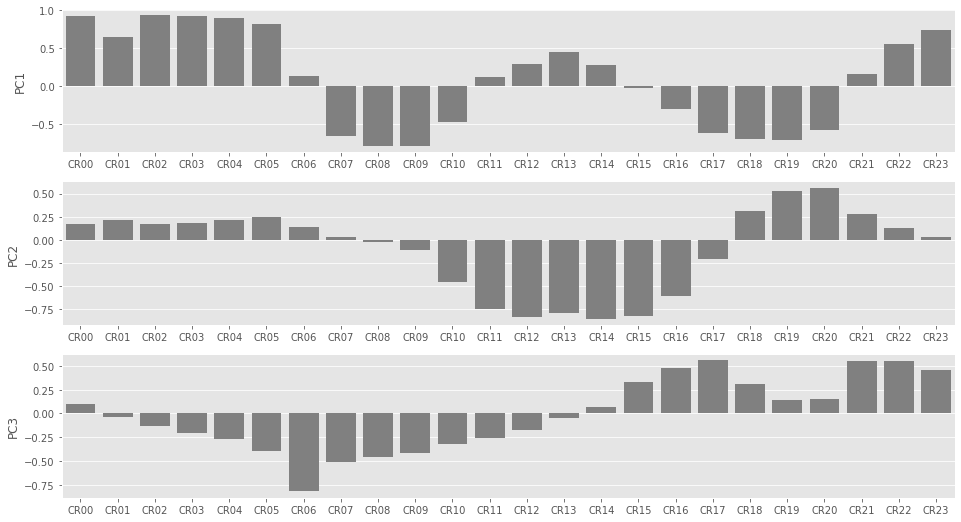

In [129]:
fig, axes = plt.subplots(3, 1, figsize=(16,9))
PC = 0
for ax in axes.ravel():
    sns.barplot(data=loadings, x=loadings.index, y=loadings.columns.values.tolist()[PC], color='gray', ax=ax)
    #ax.set_ylim(-0.1, 0.1)
    PC += 1


A new DataFrame called df_pca will be created from the first three principal components calculated in the previous steps.

In [130]:
df_pca=pd.DataFrame(X_pca[:,0:3], columns=['PC1', 'PC2', 'PC3'])

It can be verified that the dataframe df_pca has 2879 rows as the original dataset df_aju.

In [131]:
df_pca.shape

(2879, 3)

In [132]:
df_aju.shape

(2879, 30)

A new dataframe df_aju_pca will be created by joining the columns that do not have the CR... variables and the 3 main components.

In [133]:
df_aju_pca=pd.concat([df_aju[[j for j in df_aju.columns if 'CR' not in j]], df_pca], axis=1)

A pairplot is plotted showing the relationship between all variables with the output variable 'FESTIVO'. It is difficult to visualise a boundary because of the unbalance. Moreover, the correlations between the variables would not be good, as the dataframe is unbalanced.
<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v17.png' style='width:700px;'/></td></tr></table>

Therefore, a balanced dataset is created by a subsample.

In [134]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
df_aju_pca_0=df_aju_pca[df_aju_pca['FESTIVO']==0]
df_aju_pca_1=df_aju_pca[df_aju_pca['FESTIVO']==1]
print('Shape of df_aju_0:', df_aju_pca_0.shape)
print('Shape of df_aju_1:', df_aju_pca_1.shape)
df_aju_pca_0=df_aju_pca_0.sample(df_aju_pca_1.shape[0],replace=False, random_state=0)
df_aju_pca_balanced=pd.concat([df_aju_pca_0,df_aju_pca_1], axis=0)

Shape of df_aju_0: (2764, 9)
Shape of df_aju_1: (115, 9)


Se comprueba que estén equilibrados:

In [135]:
df_aju_pca_balanced_0=df_aju_pca_balanced[df_aju_pca_balanced['FESTIVO']==0]
df_aju_pca_balanced_1=df_aju_pca_balanced[df_aju_pca_balanced['FESTIVO']==1]
print('Shape of df_aju_0:', df_aju_pca_balanced_0.shape)
print('Shape of df_aju_1:', df_aju_pca_balanced_1.shape)

Shape of df_aju_0: (115, 9)
Shape of df_aju_1: (115, 9)


In [136]:
df_aju_pca_balanced

,FECHA,MES,DIASEM,FESTIVO,TMIN,TMAX,PC1,PC2,PC3
2254,2020-04-01,4,3,0,13.5,21.9,7.896628,-1.254768,0.613959
1084,2017-01-04,1,3,0,12.6,21.3,-3.285876,0.749792,0.766653
1399,2017-11-18,11,6,0,17.4,23.0,-1.030890,0.592631,-0.783767
511,2015-06-06,6,6,0,19.8,27.3,-1.321254,-4.268965,3.090547
1829,2019-01-27,1,7,0,12.5,21.3,0.050419,0.616663,-0.093958
...,...,...,...,...,...,...,...,...,...
2776,2021-09-15,9,3,1,20.5,29.1,0.653402,0.301368,2.548446
2803,2021-10-12,10,2,1,17.1,28.0,2.722674,1.721222,0.010670
2822,2021-11-01,11,1,1,16.2,27.7,-0.705473,1.518939,-0.827143
2855,2021-12-08,12,3,1,14.1,22.2,0.283248,2.062864,-0.720985


A new pairplot plot is showed.

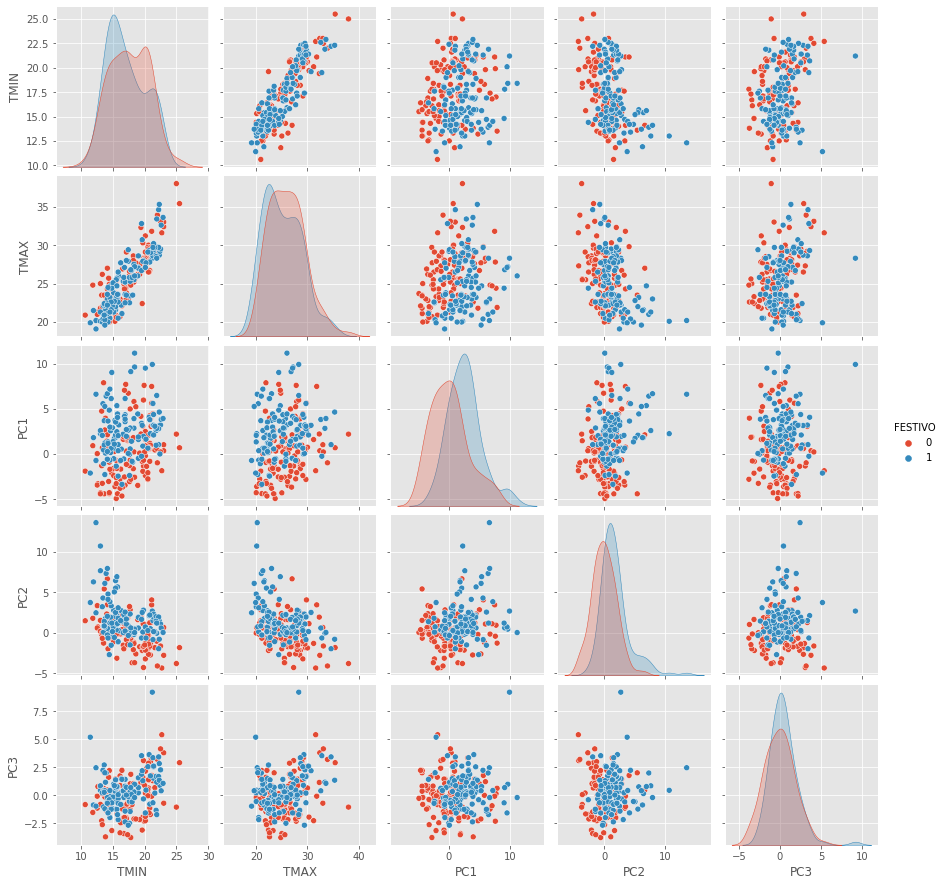

In [137]:
sns.pairplot(data=df_aju_pca_balanced, hue='FESTIVO')

You can see the correlation of each dataframe variable with the variable "FESTIVO":

The variable PC2 has a higher correlation with the variable "HOLIDAY" than the other variables.

In [138]:
df_aju_pca_balanced['FESTIVO']=df_aju_pca_balanced['FESTIVO'].astype('int')
corr = df_aju_pca_balanced.corr()
corr["FESTIVO"].sort_values()

TMAX      -0.114096
TMIN      -0.089483
PC3        0.131443
PC2        0.375776
PC1        0.382424
FESTIVO    1.000000
Name: FESTIVO, dtype: float64

In addition, the correlation matrix is plotted to see if there are any correlated variables. TMAX and TMIN are still correlated.

<AxesSubplot: >

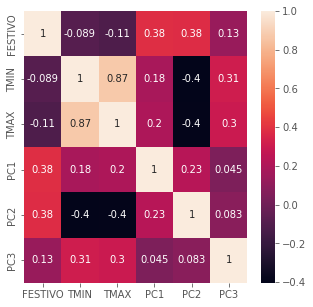

In [139]:
sub_sample_corr = df_aju_pca_balanced.corr()
plt.figure(figsize=(5,5)) 
sns.heatmap(sub_sample_corr, annot=True) 

The data will be prepared to train the tree model with the collected information based on Principal Component Analysis (PCA). Dummy variables are created for the categorical variables 'MONTH' and 'DAY_WEEK'.

In [140]:
df_aju_pca

,FECHA,MES,DIASEM,FESTIVO,TMIN,TMAX,PC1,PC2,PC3
0,2014-01-01,1,3,1,12.3,20.2,6.630428,13.617426,2.451186
1,2014-01-02,1,4,0,12.0,20.1,-2.806916,5.355132,3.301188
2,2014-01-03,1,5,0,13.2,21.0,-2.520343,5.852746,2.150044
3,2014-01-04,1,6,0,14.4,23.4,-0.692846,3.854453,2.989466
4,2014-01-05,1,7,0,12.8,23.1,1.348085,5.424169,2.425539
...,...,...,...,...,...,...,...,...,...
2874,2021-12-27,12,1,0,16.1,23.0,-2.520918,-1.036288,-1.351849
2875,2021-12-28,12,2,0,16.6,22.7,-2.284962,1.083451,-2.139885
2876,2021-12-29,12,3,0,14.3,21.3,-1.906925,1.411830,-2.508470
2877,2021-12-30,12,4,0,13.4,26.4,-2.123271,1.849650,-1.038175


In [141]:
df_aju_pca['FESTIVO'] = df_aju_pca['FESTIVO'].astype('category')
df_aju_pca['DIASEM'] = df_aju_pca['DIASEM'].astype('category')
df_aju_pca['MES'] = df_aju_pca['MES'].astype('category')

## Inputs of the model
INPUTS_NUM_PCA = df_aju_pca.select_dtypes(include=['int64','float64']).columns.values.tolist()
INPUTS_CAT_1 =  df_aju_pca.select_dtypes(include=['category']).columns.values.tolist()
INPUTS_CAT_PCA = [col for col in INPUTS_CAT_1 if col != 'FESTIVO' and col != 'FECHA']
print('Inputs numéricos:', INPUTS_NUM_PCA)
print('Inputs categóricos:', INPUTS_CAT_PCA)
INPUTS_PCA = INPUTS_NUM_PCA + INPUTS_CAT_PCA
OUTPUT_PCA = 'FESTIVO'

# Preprocess the variables when training the model
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())]) 
# Preprocess the variables when training the model 

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))]) 
## DUMMY VARIABLES

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_PCA),
        ('cat', categorical_transformer, INPUTS_CAT_PCA)
        ])

df_aju_pca_enc = preprocessor.fit_transform(df_aju_pca[INPUTS_PCA])
# Get the names of the encoded variables
INPUTS_CAT_PCA = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(INPUTS_CAT_PCA))
# Create a dataframe with the encoded variables
df_aju_pca_enc = pd.DataFrame(df_aju_pca_enc, columns=INPUTS_NUM_PCA + INPUTS_CAT_PCA)
INPUTS_PCA=[]
INPUTS_PCA = INPUTS_NUM_PCA + INPUTS_CAT_PCA
print(INPUTS_PCA)

Inputs numéricos: ['TMIN', 'TMAX', 'PC1', 'PC2', 'PC3']
Inputs categóricos: ['MES', 'DIASEM']
['TMIN', 'TMAX', 'PC1', 'PC2', 'PC3', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12', 'DIASEM_2', 'DIASEM_3', 'DIASEM_4', 'DIASEM_5', 'DIASEM_6', 'DIASEM_7']


In [142]:
df_aju_pca_enc

,TMIN,TMAX,PC1,PC2,PC3,MES_2,MES_3,MES_4,MES_5,MES_6,...,MES_9,MES_10,MES_11,MES_12,DIASEM_2,DIASEM_3,DIASEM_4,DIASEM_5,DIASEM_6,DIASEM_7
0,-1.674576,-1.529051,2.156503,6.114516,1.321905,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.771934,-1.556251,-0.912931,2.404569,1.780304,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.382502,-1.311456,-0.819725,2.628008,1.159501,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.993070,-0.658671,-0.225343,1.730732,1.612195,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.512313,-0.740269,0.438456,2.435568,1.308074,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,-0.441375,-0.767469,-0.819912,-0.465315,-0.729041,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2875,-0.279111,-0.849067,-0.743169,0.486493,-1.154023,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2876,-1.025523,-1.229858,-0.620215,0.633942,-1.352798,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2877,-1.317597,0.157311,-0.690580,0.830533,-0.559880,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


As before, the dataset is separated into training and test datasets before oversampling to avoid overfitting.

In [143]:
X = df_aju_pca_enc[INPUTS_PCA]
y = df_aju[OUTPUT]
# Split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0, #seed for replication
                                                    stratify = y)   #Preserves distribution of y

print('Shape of X_train:', X_train_pca.shape)
print('Shape of X_test:', X_test_pca.shape)
print('Shape of y_train:', y_train_pca.shape)
print('Shape of y_test:', y_test_pca.shape)

Shape of X_train: (2303, 22)
Shape of X_test: (576, 22)
Shape of y_train: (2303,)
Shape of y_test: (576,)


The oversample is always performed during the grid_search to avoid overfitting (i.e. it will be performed after the data is separated). A grid_search is defined to get the optimal number of hyperparameters to maximise the balanced_accuracy.

In [144]:
smote = SMOTE(sampling_strategy='minority', random_state=0)

INPUTS_DT_PCA = INPUTS_PCA
# Define the pipeline with preprocessing, SMOTE and decision tree classifier
pipe = ImbPipeline(steps=[
    ('smote', smote),
    ('DT', DecisionTreeClassifier(criterion='gini', random_state=0))
])

# Define the grid search parameters as before
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005),
         'DT__min_samples_leaf': np.arange(1,10,1),
         'DT__min_samples_split':  np.arange(2,10,1)}

# Use GridSearchCV from sklearn with the imbalanced pipeline
nFolds = 10
tree_fit_pca = GridSearchCV(estimator=pipe,
                        param_grid=param,
                        n_jobs=-1,
                        #especifica la métrica que se utilizará para evaluar el rendimiento del modelo.
                        scoring='balanced_accuracy', 
                        cv=nFolds)

# Fit the model with X_train and y_train as before
tree_fit_pca.fit(X_train_pca[INPUTS_DT_PCA], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=0,
                                              sampling_strategy='minority')),
                                       ('DT',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='balanced_accuracy')

Below, it can be observed the hyper-parameters that maximise the balanced_accuracy:

In [145]:
tree_fit_pca.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.04,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

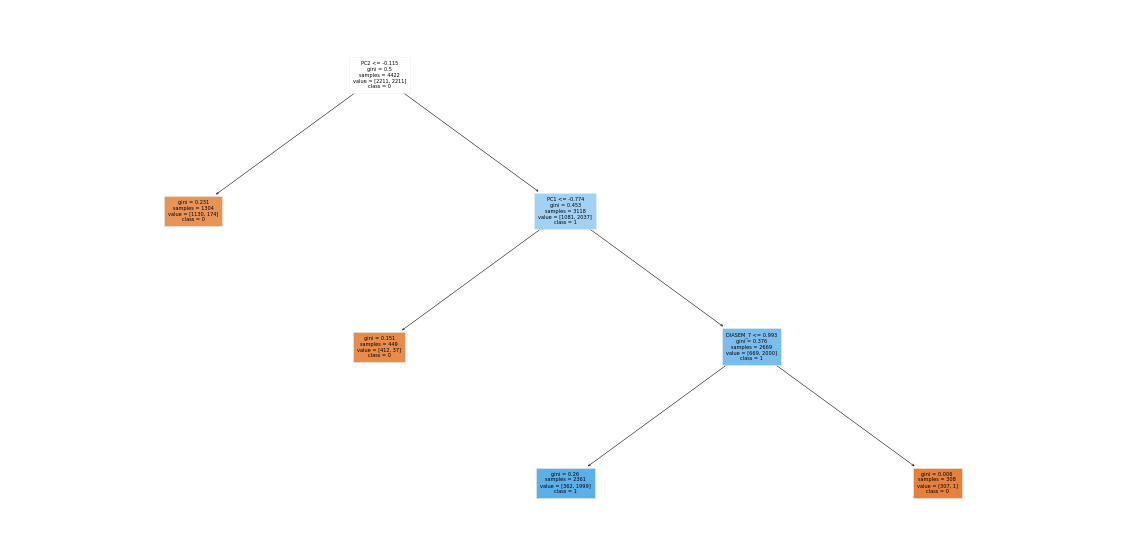

In [146]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
plt.figure(figsize=(20, 10))
plot_tree(tree_fit_pca.best_estimator_['DT'],
          feature_names= INPUTS_DT_PCA,
          class_names= [str(s) for s in y_train.unique()],
          fontsize=5, filled=True)
plt.show()

You can see the confusion matrix of the decision tree model trained with GridSearchCV.
It can be seen that they have good train and test accuracies, but it is only one tree so there may be high variance.

In [147]:
# model predictions in training (TR) and test (TS) sets
clf = tree_fit_pca.best_estimator_['DT']
y_train_pred_pca = clf.predict(X_train_pca[INPUTS_DT_PCA]).tolist()
y_test_pred_pca = clf.predict(X_test_pca[INPUTS_DT_PCA]).tolist()
Train1['DT_PCA']=y_train_pred_pca
Test1['DT_PCA']=y_test_pred_pca

# main metrics
acc_tr = metrics.accuracy_score(y_train_pca,y_train_pred_pca)
acc_ts = metrics.accuracy_score(y_test_pca,y_test_pred_pca)

acc_bal_tr = metrics.balanced_accuracy_score(y_train,y_train_pred_pca)
acc_bal_ts = metrics.balanced_accuracy_score(y_test,y_test_pred_pca)

dfacc =  pd.DataFrame([[acc_tr, acc_ts], [acc_bal_tr, acc_bal_ts]], 
                      index= ['Accuracy', 'Balanced accuracy'],  columns=['TR', 'TS'])
print(dfacc)

print('\nMETRICS TRAINING:')
CT.confusion_matrix(y_train_pca, y_train_pred_pca, labels=[0,1])

                         TR        TS
Accuracy           0.837169  0.835069
Balanced accuracy  0.847484  0.830765

METRICS TRAINING:
Confusion Matrix and Statistics
	   Prediction
 Reference    0   1
         0 1849 362
         1   13  79

Accuracy: 0.84
No Information Rate: 0.78
P-Value [Acc > NIR]: 1.0
Kappa: 0.25
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.86
Specificity: 0.84
Precision: 0.99
Recall: 0.84
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.19
Balanced accuracy: 0.85
F1 Score: 0.91
Positive label: 0


In [148]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_test_pca, y_test_pred_pca, labels=[0,1])


METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 462 91
         1   4 19

Accuracy: 0.84
No Information Rate: 0.78
P-Value [Acc > NIR]: 1.0
Kappa: 0.24
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.83
Specificity: 0.84
Precision: 0.99
Recall: 0.84
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.19
Balanced accuracy: 0.83
F1 Score: 0.91
Positive label: 0


You can see the most important variables that have been used for the model with all variables. In this case, the most important variable is PC2:

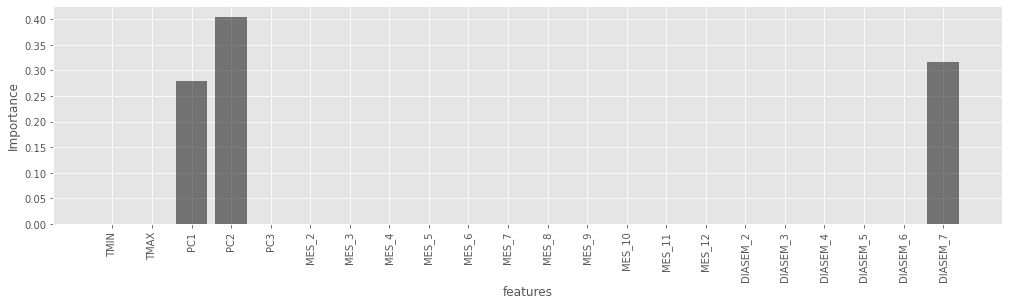

In [149]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
plt.figure(figsize=(17, 4))
bar_width = 0.35
plt.bar(INPUTS_DT_PCA, tree_fit_pca.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

---
## 1.8 COMPARISON OF ALL MODELS CREATED IN TERMS OF COMPLEXITY, INTERPRETABILITY AND ERRORS


### 1.8.1 IMPACTS OF HAVING UNBALANCED MODELS

As explained in the previous sections, the dataset is very unbalanced and therefore oversample techniques such as SMOTE had to be applied in training to deal with this problem. Furthermore, it is important to apply balancing during the grid search and not before separating the data into training and test to avoid the data leakage explained above. Therefore, the models have been trained correctly because the metrics : balanced and balanced_accuracy of the training dataset are similar. Afterwards, these two metrics in test are more unequal because in production we will receive a dataset that is very unbalanced and there is no remedy for it.

### 1.8.2 COMPLEXITY AND STUDY OF THE MODELS.

In the following table there is a summary of the most important variables in each model.


$$
\quad\\
\begin{array}{|c|c|}
\hline
\text{Model} & \text{Variables más importantes} \\ \\
\hline
\text{Decision Tree} &  \text{CR07, CR08, CR15, DIASEM6, DIASEM7} \\ \\
\hline
\text{Bagged Tree} & \text{CR07, CR08, CR15, CR19, CR20, MES6, MES12, DIASEM6, DIASEM7}  \\ \\
\hline
\text{Random Forest} & \text{CR07, CR20, MES6, MES7, DIASEM6, DIASEM7 (permutada)} \\  
 & \text{CR04, CR08, CR15 (default)} \\
\hline
\text{Gradient Boosting} & \text{CR05, CR07, CR08, CR14, CR15, CR17, CR19, CR19, CR20}  \\
& \text{TMAX, DIASEM6, DIASEM7} \\
\hline
\text{Stacking} & ALL \\
\hline
\text{PCA Decision Tree} & \text{PC1, PC2, PC3, TMAX, TMIN, DIASEM, MES}  \\ \\
\hline
\end{array}
\quad\\
$$


As can be seen, CR07 is the most used variable in all of them, followed by CR15 and CR08. In addition to DIASEM6 and DIASEM7. In the confusion matrix in section 1, it was observed that this variable is highly correlated with the output.


* In the decision tree, the most important variables are 5. The decision tree has very good results but it is a model with high variance, therefore it cannot be a very reliable model to put into production, as low bias and low variance is sought. It is observed that the model has a depth of 4 and 11 nodes. For the hyperparameters of the best model, the following have been chosen 
    * min_impurity_decrease: 0.01
    * min_samples_leaf: 1
    * min_samples_split: 2 
    
    This indicates that it is a simple model, with few cuts and that to continue growing it requires a minimum impurity decrement of 0.01, which is quite acceptable.


<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v18.png' style='width:700px;'/></td></tr></table>


* In the bagged tree, there are more variables that contribute to the model. Although it comes out with worse metrics than the decision tree, it is a more reliable model because several trees have been created that vote for each other and the vote of the majority is the vote that is chosen (although it could be that the majority is wrong). In this way high variance can be avoided and therefore these trees are allowed to grow as much as they need to.
In this model the following hyperparameters have been introduced:
    - number_estimators = 15 
    - min_samples_split = 2
    - min_samples_leaf = 1

    Which, as can be seen, are suitable, as we require the trees to go deeper, and also few trees are used, which always helps to have a more robust (less complex) model.
    As can be seen in the image below, they are deep trees (between 12 and 20 deep) and with many nodes.


<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v19.png' style='width:700px;'/></td></tr></table>

* In the random forest, more variables have been chosen because more heterogeneous trees are desired. This model is a bagged tree where the trees are limited in the variables that can be chosen to make the cuts, thus reducing the variance. The hyperparameters used are:
    - number_estimators = 45
    - max_features = 8
    - min_samples_split = 2
    - min_samples_leaf = 1
    
    As can be seen, there is a reduced number of trees, which helps to prevent the model from being too complex.
    It can be seen that this model has more nodes than the bagged tree and similar depth.
    
<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v20.png' style='width:700px;'/></td></tr></table>

* In gradient boosting, 400 trees have been chosen, because they are weak trees that learn from each other. The number of trees is usually high compared to the other models explained above. It is also less interpretable than the others. As can be seen in the image, it is a tree of depth 2 with 7 nodes.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v21.png' style='width:700px;'/></td></tr></table>

* In the stacking, the best random forest, gradient boosting and bagged tree models have been chosen. Weights have been set for each model, where the highest weight is the random forest, followed by gradient boosting and the lowest weight is the bagged tree. In this case, all the variables have been maintained. We have tried to work with different stacking models, in order to be able to choose which variables to introduce in each model, but no suitable solution has been found.

* In the PCA decision tree, when doing a principal component analysis, 3 principal components have been chosen to represent the problem, since an interval has been reached where a reasonable loss of information can be allowed. In addition, the variables TMAX, TMIN, DIASEM and MONTH have been chosen.

### 1.8.3 FAILURE RATE FOR EACH DAY FOR EACH MODEL.



In [150]:
# Sum columns in a dataframe DIASEM
Test1['DIASEM_1']=Test1['DIASEM_2']+Test1['DIASEM_3']+Test1['DIASEM_4']+Test1['DIASEM_5']+Test1['DIASEM_6']+Test1['DIASEM_7']
# replace the values of the column DIASEM_1 1 with 0 and 0 with 1
Test1['DIASEM_1'] = Test1['DIASEM_1'].replace([0,1], [1,0])

In [151]:
def diamal(modelo, dia_semana, dataset):
    """
    Función que devuelve el número de días malos de un modelo en un día de la semana
    
    modelo: modelo de predicción
    dia_semana: día de la semana
    dataset: dataset de test

    """
    a=dataset.loc[(dataset['DIASEM_{0}'.format(dia_semana)]==1) & ((dataset['FESTIVO']==0) & (dataset[modelo]==1)) | 
                ((dataset['FESTIVO']==1) & (dataset[modelo]==0)), ['DT','FESTIVO']].shape[0]
    return a

In [152]:
def mas_errores(modelo,dataset):
    """
    Función que devuelve el día de la semana con más errores de un modelo

    modelo: modelo de predicción
    dataset: dataset de test

    """
    t=[]
    for j in range(1,8):
        t.append(diamal(modelo,j,dataset))

    dia_mal=np.argmax(t)+1
    print('El día de la semana con más errores es el día {0} para el modelo {1}'
           ' con {2} días mal clasificados'.format(dia_mal, modelo,t[dia_mal-1]))

In [153]:
def tasa_fallo(modelo,dataset):
    """
    Función que devuelve la tasa de fallo de un modelo

    modelo: modelo de predicción
    dataset: dataset de test

    """
    tasa_fallo=[]
    for j in range(1,8):
        tasa_fallo.append(diamal(modelo,j,dataset)/dataset[dataset['DIASEM_{0}'.format(j)]==1].shape[0]*100)

    return tasa_fallo

#### 1.8.3.1 Decision Tree
Using the above functions, the failure rate for each day will be calculated for the decision tree model:

In [157]:
for j in range(1,8):
    print('Day {0}  has fas a failure rate of {1:.2f}%'.format(j,tasa_fallo('DT',Test1)[j-1]))

Day 1  has fas a failure rate of 11.96%
Day 2  has fas a failure rate of 16.67%
Day 3  has fas a failure rate of 15.28%
Day 4  has fas a failure rate of 16.67%
Day 5  has fas a failure rate of 16.67%
Day 6  has fas a failure rate of 17.39%
Day 7  has fas a failure rate of 6.25%


#### 1.8.3.2 Bagged Tree


In [158]:
for j in range(1,8):
    print('Day {0}  has fas a failure rate of {1:.2f}%'.format(j,tasa_fallo('BG',Test1)[j-1]))

Day 1  has fas a failure rate of 8.70%
Day 2  has fas a failure rate of 12.82%
Day 3  has fas a failure rate of 9.72%
Day 4  has fas a failure rate of 10.26%
Day 5  has fas a failure rate of 11.90%
Day 6  has fas a failure rate of 7.61%
Day 7  has fas a failure rate of 8.75%


#### 1.8.3.3 Random Forest



In [159]:
for j in range(1,8):
    print('Day {0}  has fas a failure rate of {1:.2f}%'.format(j,tasa_fallo('RF',Test1)[j-1]))

Day 1  has fas a failure rate of 8.70%
Day 2  has fas a failure rate of 8.97%
Day 3  has fas a failure rate of 9.72%
Day 4  has fas a failure rate of 10.26%
Day 5  has fas a failure rate of 8.33%
Day 6  has fas a failure rate of 8.70%
Day 7  has fas a failure rate of 8.75%


#### 1.8.3.4 Gradient Boosting


In [205]:
for j in range(1,8):
    print('Day {0}  has fas a failure rate of {1:.2f}%'.format(j,tasa_fallo('GB',Test1)[j-1]))

Day 1  has fas a failure rate of 8.70%
Day 2  has fas a failure rate of 10.26%
Day 3  has fas a failure rate of 9.72%
Day 4  has fas a failure rate of 11.54%
Day 5  has fas a failure rate of 8.33%
Day 6  has fas a failure rate of 8.70%
Day 7  has fas a failure rate of 8.75%


#### 1.8.3.5 Stacking


In [206]:
for j in range(1,8):
    print('Day {0}  has fas a failure rate of {1:.2f}%'.format(j,tasa_fallo('STC',Test1)[j-1]))

Day 1  has fas a failure rate of 8.70%
Day 2  has fas a failure rate of 8.97%
Day 3  has fas a failure rate of 9.72%
Day 4  has fas a failure rate of 10.26%
Day 5  has fas a failure rate of 8.33%
Day 6  has fas a failure rate of 7.61%
Day 7  has fas a failure rate of 8.75%


#### 1.8.3.6 Decision Tree PCA


In [207]:
for j in range(1,8):
    print('Day {0}  has fas a failure rate of {1:.2f}%'.format(j,tasa_fallo('DT_PCA',Test1)[j-1]))

Day 1  has fas a failure rate of 11.96%
Day 2  has fas a failure rate of 23.08%
Day 3  has fas a failure rate of 18.06%
Day 4  has fas a failure rate of 21.79%
Day 5  has fas a failure rate of 17.86%
Day 6  has fas a failure rate of 44.57%
Day 7  has fas a failure rate of 5.00%


### 1.8.4 COMPARISON BETWEEN MODELS AND CONFUSION MATRICES.

Now we will compare all the confusion matrices of the above models. It can be observed that the best matrix is the stacking one as it has the least false holidays. It can be concluded, that for predicting whether it is a holiday, stacking, random forest, bagged tree and gradient boosting have the same false working days. The results of stacking make sense, being a combination of the last 3. The decision tree and decision tree PCA model has fewer false labours, but being a model with a lot of variance it is not reliable.

<table>

<tr><td><img src='./images/v23.png' style='width:450px;'/></td>
<td><img src='./images/v22.png' style='width:450px;'/></td></tr>
<tr><td><img src='./images/v24.png' style='width:450px;'/></td>
<td><img src='./images/v25.png' style='width:450px;'/></td></tr>
<tr><td><img src='./images/v27.png' style='width:450px;'/></td>
<td><img src='./images/v26.png' style='width:450px;'/></td></tr>

</table>

Therefore, in summary we have the following table with all the models, as observed in the confusion matrices, the model that has the best accuracy_balanced is the stacking model which is a combination of random forest, bagged tree and gradient boosting which has the least false holidays and the least false working days.

$$
\quad\\
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
\text{Model} & \text{Train/Test} & \text{Accuracy} & \text{Accuracy Balanced} & \text{Sensitivity} & \text{Specificity} \\
\hline \\
 & Train & 0.9188 & 0.9079 & 0.89 & 0.92 \\ \text{Decision Tree} \\
& Test &0.9056  & 0.8479 & 0.78 & 0.91 \\ \\
\hline \\
 & Train & 0.9991 & 0.973958 & 0.98 & 1 \\ \text{Bagged Tree} \\
 & Test & 0.9891 & 0.8405 & 0.7 & 0.99 \\ \\
\hline \\
 & Train & 0.999 & 0.9826 & 1 & 1 \\ \text{Random Forest} \\
 & Test & 0.999 & 0.845 & 0.7 & 0.99 \\ \\
\hline \\
 & Train & 0.9956 & 0.9774 & 1 & 1 \\ \text{Gradient Boosting} \\
 & Test & 0.9769 & 0.8424 & 0.7 & 0.99 \\ \\
\hline \\
 & Train & 0.999 & 0.984 & 1 & 1 \\ \text{Stacking} \\
 & Test & 0.994 & 0.846 & 0.7 & 1 \\ \\
\hline \\
 & Train & 0.8371 & 0.8350 & 0.86 & 0.84 \\ \text{PCA Decision Tree} \\
 & Test & 0.8307 & 0.8474 & 0.83 & 0.84 \\ \\
\hline


\end{array}
\quad\\
$$

---
# 2. FINAL VALIDATION OF THE MODELS WITH THE DATASET VAL_DATA_DEM_C3

It would correlate as if all the models created above are put into production on 1 January 2022 and are kept estimating the holiday throughout the year to see how they perform.

Remember, you should not see any results on this dataset until you have completed all of the above.


In [163]:

df_val = pd.read_csv('VAL_DATOS_DEM_C3.csv')


df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
print(df_val)

Tamaño de df_val con los datos cargados: (357, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):
          FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0    2022-01-01  0.038935  0.037313  0.035291  0.033673  0.032924  0.033235   
1    2022-01-02  0.035271  0.033313  0.031889  0.031411  0.031302  0.031975   
2    2022-01-03  0.033756  0.032003  0.030669  0.030051  0.030199  0.031280   
3    2022-01-04  0.034484  0.032505  0.031375  0.030540  0.030431  0.031324   
4    2022-01-05  0.034669  0.032213  0.030933  0.030382  0.030527  0.031611   
..          ...       ...       ...       ...       ...       ...       ...   
352  2022-12-27  0.033279  0.031139  0.029907  0.029433  0.029757  0.030972   
353  2022-12-28  0.033250  0.031186  0.029934  0.029447  0.029821  0.030942   
354  2022-12-29  0.033718  0.031695  0.030290  0.029717  0.030014  0.031075   
355  2022-12-30  0.033673  0.031494  0.030124  0.029639  0.029629  0.030732   
356  20

In [164]:
df_val1=df_val.copy()

In [165]:
df_val['FESTIVO'] = df_val['FESTIVO'].astype('category')
df_val['DIASEM'] = df_val['DIASEM'].astype('category')
df_val['MES'] = df_val['MES'].astype('category')

## Inputs of the model
INPUTS_NUM = df_val.select_dtypes(include=['int64','float64']).columns.values.tolist()
INPUTS_CAT_1 =  df_val.select_dtypes(include=['category']).columns.values.tolist()
INPUTS_CAT = [col for col in INPUTS_CAT_1 if col != 'FESTIVO' and col != 'FECHA']
print('Inputs numéricos:', INPUTS_NUM)
print('Inputs categóricos:', INPUTS_CAT)
INPUTS = INPUTS_NUM + INPUTS_CAT
OUTPUT = 'FESTIVO'

# Preprocess the variables when training the model
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())]) # Preprocess the variables when training the model 

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM),
        ('cat', categorical_transformer, INPUTS_CAT)
        ])

df_val_enc = preprocessor.fit_transform(df_val[INPUTS])
# Get the names of the encoded variables
INPUTS_CAT = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(INPUTS_CAT))
# Create a dataframe with the encoded variables
df_val_enc = pd.DataFrame(df_val_enc, columns=INPUTS_NUM + INPUTS_CAT)
INPUTS=[]
INPUTS = INPUTS_NUM + INPUTS_CAT
print(INPUTS)

Inputs numéricos: ['CR00', 'CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07', 'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16', 'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'TMIN', 'TMAX']
Inputs categóricos: ['MES', 'DIASEM']
['CR00', 'CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07', 'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16', 'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23', 'TMIN', 'TMAX', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12', 'DIASEM_2', 'DIASEM_3', 'DIASEM_4', 'DIASEM_5', 'DIASEM_6', 'DIASEM_7']


In [166]:
X_val = df_val_enc[INPUTS]
y_val = df_val['FESTIVO']

---
## 2.1. COMPARISON OF ERRORS OBTAINED IN VALIDATION WITH THOSE PREVIOUSLY OBSERVED IN SETTING/TESTING




### 2.1.1 DECISION TREE

In [167]:
# model predictions in training (TR) and test (TS) sets
clf = tree_fit_def.best_estimator_['DT']
y_val_pred = clf.predict(X_val[INPUTS_DT_DEF]).tolist()
X_val['DT'] = y_val_pred

# main metrics
acc_val = metrics.accuracy_score(y_val,y_val_pred)
acc_bal_val = metrics.balanced_accuracy_score(y_val,y_val_pred)

dfacc =  pd.DataFrame([[acc_val], [acc_bal_val]], index= ['Accuracy', 'Balanced accuracy'],  columns=['VAL'])
print(dfacc)


print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_val, y_val_pred, labels=[0,1])

                        VAL
Accuracy           0.921569
Balanced accuracy  0.863450

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 317 25
         1   3 12

Accuracy: 0.92
No Information Rate: 0.86
P-Value [Acc > NIR]: 1.0
Kappa: 0.43
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.8
Specificity: 0.93
Precision: 0.99
Recall: 0.93
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.1
Balanced accuracy: 0.86
F1 Score: 0.96
Positive label: 0


### 2.1.2 BAGGED TREE

In [168]:

# model predictions in training (TR) and test (TS) sets
clf =  bag_def
y_val_pred = clf.predict(X_val[INPUTS_BT]).tolist()
X_val['BT'] = y_val_pred

# main metrics
acc_val = metrics.accuracy_score(y_val,y_val_pred)
acc_bal_val = metrics.balanced_accuracy_score(y_val,y_val_pred)

dfacc =  pd.DataFrame([[acc_val], [acc_bal_val]], index= ['Accuracy', 'Balanced accuracy'],  columns=['VAL'])
print(dfacc)


print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_val, y_val_pred, labels=[0,1])

                        VAL
Accuracy           0.971989
Balanced accuracy  0.857895

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 336  6
         1   4 11

Accuracy: 0.97
No Information Rate: 0.91
P-Value [Acc > NIR]: 0.11
Kappa: 0.67
Mcnemar's Test P-Value: 0.75
Sensitivity: 0.73
Specificity: 0.98
Precision: 0.99
Recall: 0.98
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.05
Balanced accuracy: 0.86
F1 Score: 0.99
Positive label: 0


### 2.1.3 RANDOM FOREST

In [169]:
# model predictions in training (TR) and test (TS) sets
clf = rf_def
y_val_pred = clf.predict(X_val[INPUTS_RF]).tolist()
X_val['RF'] = y_val_pred

# main metrics
acc_val = metrics.accuracy_score(y_val,y_val_pred)
acc_bal_val = metrics.balanced_accuracy_score(y_val,y_val_pred)

dfacc =  pd.DataFrame([[acc_val], [acc_bal_val]], index= ['Accuracy', 'Balanced accuracy'],  columns=['VAL'])
print(dfacc)


print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_val, y_val_pred, labels=[0,1])

                        VAL
Accuracy           0.974790
Balanced accuracy  0.891228

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 336  6
         1   3 12

Accuracy: 0.97
No Information Rate: 0.91
P-Value [Acc > NIR]: 0.07
Kappa: 0.71
Mcnemar's Test P-Value: 0.51
Sensitivity: 0.8
Specificity: 0.98
Precision: 0.99
Recall: 0.98
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.05
Balanced accuracy: 0.89
F1 Score: 0.99
Positive label: 0


### 2.1.4 GRADIENT BOOSTING

In [170]:
clf = gb_fit_def
y_val_pred = clf.predict(X_val[INPUTS_GB]).tolist()
X_val['GB'] = y_val_pred


# main metrics
acc_val = metrics.accuracy_score(y_val,y_val_pred)
acc_bal_val = metrics.balanced_accuracy_score(y_val,y_val_pred)

dfacc =  pd.DataFrame([[acc_val], [acc_bal_val]], index= ['Accuracy', 'Balanced accuracy'],  columns=['VAL'])
print(dfacc)


print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_val, y_val_pred, labels=[0,1])

                        VAL
Accuracy           0.977591
Balanced accuracy  0.860819

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 338  4
         1   4 11

Accuracy: 0.98
No Information Rate: 0.92
P-Value [Acc > NIR]: 0.03
Kappa: 0.72
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.73
Specificity: 0.99
Precision: 0.99
Recall: 0.99
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.04
Balanced accuracy: 0.86
F1 Score: 0.99
Positive label: 0


### 2.1.5 STACKING

In [171]:
clf = stacked_cl
y_val_pred = clf.predict(X_val[INPUTS]).tolist()
X_val['ST'] = y_val_pred
# main metrics
acc_val = metrics.accuracy_score(y_val,y_val_pred)
acc_bal_val = metrics.balanced_accuracy_score(y_val,y_val_pred)

dfacc =  pd.DataFrame([[acc_val], [acc_bal_val]], index= ['Accuracy', 'Balanced accuracy'],  columns=['VAL'])
print(dfacc)


print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_val, y_val_pred, labels=[0,1])

                        VAL
Accuracy           0.985994
Balanced accuracy  0.865205

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0  1
         0 341  1
         1   4 11

Accuracy: 0.99
No Information Rate: 0.93
P-Value [Acc > NIR]: 0.0
Kappa: 0.81
Mcnemar's Test P-Value: 0.38
Sensitivity: 0.73
Specificity: 1.0
Precision: 0.99
Recall: 1.0
Prevalence: 0.04
Detection Rate: 0.03
Detection prevalence: 0.03
Balanced accuracy: 0.87
F1 Score: 0.99
Positive label: 0


### 2.1.6 DECISION TREE PCA

In [172]:
CR_names=[i for i in df_val1.columns if 'CR' in i]
X_val_pca=df_val1[CR_names]
numeric_features = CR_names

In [173]:
scaler = StandardScaler() #Si tengo varibles en distintas unidades de medida, lo suyo es estanderizar.
X_transformed = scaler.fit_transform(X=X_val_pca)
X_val_pca=pd.DataFrame(X_transformed, columns=CR_names)

In [174]:
pca_val = PCA(n_components=X_val_pca.shape[1], random_state=0) 
# Este modelo me genera el modeo de PCA, y me genera tantas componentes como tamaño que tiene mis datos
X_pca_val = pca_val.fit_transform(X_val_pca)

In [175]:
X_val_pca_def=pd.DataFrame(X_pca_val[:,0:3], columns=['PC1', 'PC2', 'PC3'])
X_val_pca_def=pd.concat([df_val1[[j for j in df_val1.columns if 'CR' not in j]], X_val_pca_def], axis=1)
X_val_pca_def

,FECHA,MES,DIASEM,FESTIVO,TMIN,TMAX,PC1,PC2,PC3
0,2022-01-01,1,6,1,14.1,25.3,7.317530,-1.796928,3.590906
1,2022-01-02,1,7,0,14.5,24.9,1.171407,0.842798,0.385768
2,2022-01-03,1,1,0,11.3,23.8,-2.239959,0.505953,-0.362703
3,2022-01-04,1,2,0,10.8,23.0,-1.068128,-1.717003,0.269573
4,2022-01-05,1,3,0,14.7,22.2,-0.595541,-0.590867,-0.882708
...,...,...,...,...,...,...,...,...,...
352,2022-12-27,12,2,0,20.6,23.5,-4.317554,0.261054,1.922143
353,2022-12-28,12,3,0,18.7,24.1,-4.409813,2.226669,0.490368
354,2022-12-29,12,4,0,18.0,24.6,-3.993325,0.667572,0.483306
355,2022-12-30,12,5,0,15.7,24.1,-4.155876,0.640952,1.709219


In [176]:
X_val_pca_def['FESTIVO'] = X_val_pca_def['FESTIVO'].astype('category')
X_val_pca_def['DIASEM'] = X_val_pca_def['DIASEM'].astype('category')
X_val_pca_def['MES'] = X_val_pca_def['MES'].astype('category')

## Inputs of the model
INPUTS_NUM_PCA = X_val_pca_def.select_dtypes(include=['int64','float64']).columns.values.tolist()
INPUTS_CAT_1 =  X_val_pca_def.select_dtypes(include=['category']).columns.values.tolist()
INPUTS_CAT_PCA = [col for col in INPUTS_CAT_1 if col != 'FESTIVO' and col != 'FECHA']
print('Inputs numéricos:', INPUTS_NUM_PCA)
print('Inputs categóricos:', INPUTS_CAT_PCA)
INPUTS_PCA = INPUTS_NUM_PCA + INPUTS_CAT_PCA
OUTPUT_PCA = 'FESTIVO'

# Preprocess the variables when training the model
numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())]) 
# Preprocess the variables when training the model 

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))]) 
## DUMMY VARIABLES

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_NUM_PCA),
        ('cat', categorical_transformer, INPUTS_CAT_PCA)
        ])

X_val_pca_enc = preprocessor.fit_transform(X_val_pca_def[INPUTS_PCA])
# Get the names of the encoded variables
INPUTS_CAT_PCA = list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(INPUTS_CAT_PCA))
# Create a dataframe with the encoded variables
X_val_pca_enc = pd.DataFrame(X_val_pca_enc, columns=INPUTS_NUM_PCA + INPUTS_CAT_PCA)
INPUTS_PCA=[]
INPUTS_PCA = INPUTS_NUM_PCA + INPUTS_CAT_PCA
print(INPUTS_PCA)

Inputs numéricos: ['TMIN', 'TMAX', 'PC1', 'PC2', 'PC3']
Inputs categóricos: ['MES', 'DIASEM']
['TMIN', 'TMAX', 'PC1', 'PC2', 'PC3', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12', 'DIASEM_2', 'DIASEM_3', 'DIASEM_4', 'DIASEM_5', 'DIASEM_6', 'DIASEM_7']


In [177]:
X_val_pca_enc

,TMIN,TMAX,PC1,PC2,PC3,MES_2,MES_3,MES_4,MES_5,MES_6,...,MES_9,MES_10,MES_11,MES_12,DIASEM_2,DIASEM_3,DIASEM_4,DIASEM_5,DIASEM_6,DIASEM_7
0,-1.260358,-0.342561,2.433745,-0.819735,1.946279,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.125553,-0.457068,0.389600,0.384473,0.209087,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-2.203999,-0.771964,-0.744990,0.230809,-0.196586,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.372506,-1.000979,-0.355250,-0.783274,0.146109,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.058150,-1.229995,-0.198072,-0.269546,-0.478430,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.930235,-0.857845,-1.435980,0.119090,1.041806,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
353,0.289908,-0.686084,-1.466664,1.015777,0.265781,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
354,0.053998,-0.542949,-1.328144,0.304538,0.261953,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
355,-0.721135,-0.686084,-1.382207,0.292394,0.926400,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [178]:
clf = tree_fit_pca
y_val_pred = clf.predict(X_val_pca_enc[INPUTS_DT_PCA]).tolist()
X_val['CP'] = y_val_pred


# main metrics
acc_val = metrics.accuracy_score(y_val,y_val_pred)
acc_bal_val = metrics.balanced_accuracy_score(y_val,y_val_pred)

dfacc =  pd.DataFrame([[acc_val], [acc_bal_val]], index= ['Accuracy', 'Balanced accuracy'],  columns=['VAL'])
print(dfacc)


print('\nMETRICS TEST SET:')
CT.confusion_matrix(y_val, y_val_pred, labels=[0,1])

                        VAL
Accuracy           0.610644
Balanced accuracy  0.509942

METRICS TEST SET:
Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 212 130
         1   9   6

Accuracy: 0.61
No Information Rate: 0.61
P-Value [Acc > NIR]: 1.0
Kappa: 0.0
Mcnemar's Test P-Value: 0.0
Sensitivity: 0.4
Specificity: 0.62
Precision: 0.96
Recall: 0.62
Prevalence: 0.04
Detection Rate: 0.02
Detection prevalence: 0.38
Balanced accuracy: 0.51
F1 Score: 0.75
Positive label: 0


### 2.1.7 RESULTS

In general, all models show a performance equal or better than that obtained in the test, except the PCA decision tree model, which shows a significant drop in balance accuracy. This can be seen in the following table:

$$
\quad\\
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
\text{Model} & \text{Validation/Test} & \text{Accuracy} & \text{Accuracy Balanced} & \text{Sensitivity} & \text{Specificity} \\
\hline \\
 & Validation & 0.921569 & 0.863450 & 0.8 & 0.93 \\ \text{Decision Tree} \\
& Test &0.9056  & 0.8479 & 0.78 & 0.91 \\ \\
\hline \\
 & Validation & 0.971989 & 0.857895 & 0.73 & 0.98 \\ \text{Bagged Tree} \\
 & Test & 0.9891 & 0.8405 & 0.7 & 0.99 \\ \\
\hline \\
 & Validation & 0.97479 & 0.891228 & 0.8 & 0.98 \\ \text{Random Forest} \\
 & Test & 0.999 & 0.845 & 0.7 & 0.99 \\ \\
\hline \\
 & Validation & 0.977591 & 0.860819 & 073 & 0.99 \\ \text{Gradient Boosting} \\
 & Test & 0.9769 & 0.8424 & 0.7 & 0.99 \\ \\
\hline \\
 & Validation & 0.985994 & 0.865205 & 0.73 & 1 \\ \text{Stacking} \\
 & Test & 0.994 & 0.846 & 0.7 & 1 \\ \\
\hline \\
 & Validation & 0.610644 & 0.509942 & 0.4 & 0.62 \\ \text{PCA Decision Tree} \\
 & Test & 0.8307 & 0.8474 & 0.83 & 0.84 \\ \\
\hline


\end{array}
\quad\\
$$



---
## 2.2. ANALYSIS OF THE LOWEST RANKED DAYS


In [179]:
X_val=pd.concat([X_val, y_val], axis=1)

# How to sum 2 columns in a dataframe DIASEM
X_val['DIASEM_1']=X_val['DIASEM_2']+X_val['DIASEM_3']+X_val['DIASEM_4']+X_val['DIASEM_5']+X_val['DIASEM_6']+X_val['DIASEM_7']
# replace the values of the column DIASEM_1 1 with 0 and 0 with 1
X_val['DIASEM_1'] = X_val['DIASEM_1'].replace([0,1], [1,0])

First, we will obtain how badly classified each day is in each model, as well as the worst classified day, and subsequently, we will solve each of the sub-sections.

In [180]:
X_val

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,DIASEM_6,DIASEM_7,DT,BT,RF,GB,ST,CP,FESTIVO,DIASEM_1
0,3.036279,2.182622,3.801220,3.173901,2.514371,2.132613,-0.775519,-1.691518,-2.667318,-2.988139,...,1.0,0.0,0,0,0,0,0,0,1,0.0
1,0.273602,0.256084,0.495359,0.724405,0.594571,0.255410,-1.338749,-1.550369,-1.736025,-0.441758,...,0.0,1.0,0,0,0,0,0,0,0,0.0
2,-0.868288,-0.374740,-0.689313,-0.748667,-0.711535,-0.779956,-0.804367,-0.345307,-0.031637,0.584871,...,0.0,0.0,1,1,1,1,0,1,0,1.0
3,-0.319418,-0.133020,-0.003655,-0.218923,-0.437274,-0.714588,-0.011784,0.130562,0.226250,0.352061,...,0.0,0.0,0,0,0,0,0,0,0,0.0
4,-0.180053,-0.273458,-0.433168,-0.390860,-0.323999,-0.286705,-0.205009,-0.216228,-0.194684,0.820014,...,0.0,0.0,1,1,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,-1.227702,-0.791006,-1.430348,-1.417986,-1.235532,-1.239566,-0.284344,-0.073641,0.449152,0.836914,...,0.0,0.0,0,0,0,0,0,0,0,0.0
353,-1.249931,-0.768379,-1.403511,-1.402714,-1.159584,-1.283353,-1.232354,-0.361790,0.082337,0.997809,...,0.0,0.0,0,0,0,0,0,0,0,0.0
354,-0.897267,-0.522929,-1.057502,-1.110185,-0.930976,-1.086060,-0.382784,-0.065997,0.589894,1.110108,...,0.0,0.0,1,0,1,0,0,0,0,0.0
355,-0.931052,-0.620104,-1.219223,-1.195276,-1.387450,-1.596788,-1.236886,-0.378491,0.491375,1.222923,...,0.0,0.0,1,0,0,0,0,0,0,0.0


In [208]:
def mas_errores(modelo,dataset):
    """
    Función que devuelve el día de la semana con más errores de un modelo

    modelo: modelo de predicción
    dataset: dataset de test

    """
    t=[]
    for j in range(1,8):
        t.append(diamal(modelo,j,dataset))

    dia_mal=np.argmax(t)+1
    print('The day of the week with the most errors is day {0} for model {1}'
           ' with {2} days misclassified'.format(dia_mal, modelo,t[dia_mal-1]))

### % Failure rate DT, by days

In [209]:
for j in range(1,8):
    print('Day {0} has a failure rate of {1}%'.format(j,tasa_fallo('DT',X_val)[j-1]))

Day 1 has a failure rate of 11.538461538461538%
Day 2 has a failure rate of 7.6923076923076925%
Day 3 has a failure rate of 14.285714285714285%
Day 4 has a failure rate of 15.384615384615385%
Day 5 has a failure rate of 16.0%
Day 6 has a failure rate of 18.867924528301888%
Day 7 has a failure rate of 6.122448979591836%


In [210]:
mas_errores('DT',X_val)

The day of the week with the most errors is day 6 for model DT with 10 days misclassified


### % Failure rate BT, by days

In [211]:
for j in range(1,8):
    print('Day {0} has a failure rate of {1}%'.format(j,tasa_fallo('BT',X_val)[j-1]))

Day 1 has a failure rate of 9.615384615384617%
Day 2 has a failure rate of 7.6923076923076925%
Day 3 has a failure rate of 12.244897959183673%
Day 4 has a failure rate of 9.615384615384617%
Day 5 has a failure rate of 10.0%
Day 6 has a failure rate of 7.547169811320755%
Day 7 has a failure rate of 10.204081632653061%


In [212]:
mas_errores('BT',X_val)

The day of the week with the most errors is day 3 for model BT with 6 days misclassified


### % Failure rate RF, by days

In [213]:
for j in range(1,8):
    print('Day {0} has a failure rate of {1}%'.format(j,tasa_fallo('RF',X_val)[j-1]))

Day 1 has a failure rate of 7.6923076923076925%
Day 2 has a failure rate of 5.769230769230769%
Day 3 has a failure rate of 10.204081632653061%
Day 4 has a failure rate of 9.615384615384617%
Day 5 has a failure rate of 8.0%
Day 6 has a failure rate of 5.660377358490567%
Day 7 has a failure rate of 6.122448979591836%


In [214]:
mas_errores('RF',X_val)

The day of the week with the most errors is day 3 for model RF with 5 days misclassified


### % Failure rate GB , by days

In [215]:
for j in range(1,8):
    print('Day {0} has a failure rate of {1}%'.format(j,tasa_fallo('GB',X_val)[j-1]))

Day 1 has a failure rate of 9.615384615384617%
Day 2 has a failure rate of 7.6923076923076925%
Day 3 has a failure rate of 12.244897959183673%
Day 4 has a failure rate of 7.6923076923076925%
Day 5 has a failure rate of 8.0%
Day 6 has a failure rate of 9.433962264150944%
Day 7 has a failure rate of 8.16326530612245%


In [216]:
mas_errores('GB',X_val)

The day of the week with the most errors is day 3 for model GB with 6 days misclassified


### % Failure rate ST, by days

In [217]:
for j in range(1,8):
    print('Day {0} has a failure rate of {1}%'.format(j,tasa_fallo('ST',X_val)[j-1]))

Day 1 has a failure rate of 7.6923076923076925%
Day 2 has a failure rate of 7.6923076923076925%
Day 3 has a failure rate of 10.204081632653061%
Day 4 has a failure rate of 7.6923076923076925%
Day 5 has a failure rate of 8.0%
Day 6 has a failure rate of 7.547169811320755%
Day 7 has a failure rate of 8.16326530612245%


In [218]:
mas_errores('ST',X_val)

The day of the week with the most errors is day 3 for model ST with 5 days misclassified


### % Failure rate DT PCA, by days

In [219]:
for j in range(1,8):
    print('Day {0} has a failure rate of {1}%'.format(j,tasa_fallo('CP',X_val)[j-1]))

Day 1 has a failure rate of 51.92307692307693%
Day 2 has a failure rate of 53.84615384615385%
Day 3 has a failure rate of 57.14285714285714%
Day 4 has a failure rate of 48.07692307692308%
Day 5 has a failure rate of 56.00000000000001%
Day 6 has a failure rate of 90.56603773584906%
Day 7 has a failure rate of 18.367346938775512%


In [220]:
mas_errores('CP',X_val)

The day of the week with the most errors is day 6 for model CP with 48 days misclassified


### 2.2.1 TABLE OF DAYS THAT HAVE BEEN INCORRECTLY CLASSIFIED BY EACH OF THE MODELS UNDER CONSIDERATION

In [221]:
X_val

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,DIASEM_6,DIASEM_7,DT,BT,RF,GB,ST,CP,FESTIVO,DIASEM_1
0,3.036279,2.182622,3.801220,3.173901,2.514371,2.132613,-0.775519,-1.691518,-2.667318,-2.988139,...,1.0,0.0,0,0,0,0,0,0,1,0.0
1,0.273602,0.256084,0.495359,0.724405,0.594571,0.255410,-1.338749,-1.550369,-1.736025,-0.441758,...,0.0,1.0,0,0,0,0,0,0,0,0.0
2,-0.868288,-0.374740,-0.689313,-0.748667,-0.711535,-0.779956,-0.804367,-0.345307,-0.031637,0.584871,...,0.0,0.0,1,1,1,1,0,1,0,1.0
3,-0.319418,-0.133020,-0.003655,-0.218923,-0.437274,-0.714588,-0.011784,0.130562,0.226250,0.352061,...,0.0,0.0,0,0,0,0,0,0,0,0.0
4,-0.180053,-0.273458,-0.433168,-0.390860,-0.323999,-0.286705,-0.205009,-0.216228,-0.194684,0.820014,...,0.0,0.0,1,1,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,-1.227702,-0.791006,-1.430348,-1.417986,-1.235532,-1.239566,-0.284344,-0.073641,0.449152,0.836914,...,0.0,0.0,0,0,0,0,0,0,0,0.0
353,-1.249931,-0.768379,-1.403511,-1.402714,-1.159584,-1.283353,-1.232354,-0.361790,0.082337,0.997809,...,0.0,0.0,0,0,0,0,0,0,0,0.0
354,-0.897267,-0.522929,-1.057502,-1.110185,-0.930976,-1.086060,-0.382784,-0.065997,0.589894,1.110108,...,0.0,0.0,1,0,1,0,0,0,0,0.0
355,-0.931052,-0.620104,-1.219223,-1.195276,-1.387450,-1.596788,-1.236886,-0.378491,0.491375,1.222923,...,0.0,0.0,1,0,0,0,0,0,0,0.0


In [222]:
df = X_val.loc[(X_val['DT'] != X_val['FESTIVO']) | (X_val['RF'] != X_val['FESTIVO']) | (X_val['BT'] != X_val['FESTIVO']) | (X_val['GB'] != X_val['FESTIVO']) | (X_val['ST'] != X_val['FESTIVO']) | (X_val['CP'] != X_val['FESTIVO']), ['DT', 'RF', 'BT','GB' ,'ST', 'CP', 'FESTIVO']]
df

,DT,RF,BT,GB,ST,CP,FESTIVO
0,0,0,0,0,0,0,1
2,1,1,1,1,0,1,0
4,1,0,1,1,0,0,0
5,1,1,1,1,1,0,1
6,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
333,1,1,0,1,1,1,1
335,0,0,0,0,0,1,0
351,1,0,1,0,0,1,1
354,1,1,0,0,0,0,0


### 2.2.2 POSSIBLE DIFFERENCES AND SIMILARITIES, TRYING TO FIND A JUSTIFICATION FOR WHY THE MISCLASSIFICATION HAS OCCURRED.

Ignoring the mediocre performance of the decision tree model of the principal components, to see how poorly the models have ranked overall, it will be considered that for misclassification to have occurred, at least 3 or more models must have failed.

In [223]:
#calculamos el nº de fallos por fila
n_fallos = []
for i in range(len(df)):
    n_fallos.append(sum(df.iloc[i][['DT', 'RF', 'BT', 'ST', 'GB', 'CP']] != df.iloc[i]['FESTIVO']))

df_sem=df.copy()    
df_sem['N_de_fallos'] = n_fallos

#solo queremos aquellos n_fallosque sean mayores que 3
df_sem = df_sem.loc[df_sem['N_de_fallos'] >= 3]
df_sem.reset_index(drop=False, inplace=True)
indices_sem=df_sem['index']
filas_sem = X_val.loc[indices_sem]
filas_sem


,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,DIASEM_6,DIASEM_7,DT,BT,RF,GB,ST,CP,FESTIVO,DIASEM_1
0,3.036279,2.182622,3.801220,3.173901,2.514371,2.132613,-0.775519,-1.691518,-2.667318,-2.988139,...,1.0,0.0,0,0,0,0,0,0,1,0.0
2,-0.868288,-0.374740,-0.689313,-0.748667,-0.711535,-0.779956,-0.804367,-0.345307,-0.031637,0.584871,...,0.0,0.0,1,1,1,1,0,1,0,1.0
4,-0.180053,-0.273458,-0.433168,-0.390860,-0.323999,-0.286705,-0.205009,-0.216228,-0.194684,0.820014,...,0.0,0.0,1,1,0,1,0,0,0,0.0
120,-0.211102,-0.148765,-0.464114,-0.146795,-0.018159,0.160077,1.683856,1.035314,0.927256,0.520935,...,0.0,0.0,0,0,0,0,0,0,1,1.0
200,0.786062,0.435995,0.731354,0.584881,0.667343,0.473999,-1.392021,-1.506656,-1.774336,-1.620731,...,1.0,0.0,1,0,0,1,0,1,0,0.0
225,-0.024379,0.091505,0.148092,0.170335,0.307679,0.101802,-0.493856,-0.679206,-0.460104,-0.807126,...,0.0,0.0,1,0,1,0,0,1,0,0.0
226,0.570546,0.154146,0.223666,0.059260,-0.019598,-0.269908,-0.957665,-0.769534,-0.623012,-0.321621,...,0.0,0.0,1,1,1,0,0,1,0,0.0
232,0.631018,0.319480,0.743631,0.556581,0.575280,0.241866,-0.446943,-0.605005,-0.766182,-1.096588,...,0.0,0.0,1,1,1,1,1,1,0,0.0
234,0.791420,0.322102,0.429328,0.078497,-0.109633,-0.548951,-0.993052,-0.631249,-0.755250,-0.527949,...,0.0,0.0,1,1,1,0,0,1,0,0.0
331,-0.203298,-0.070721,-0.062525,-0.037255,-0.078528,-0.277197,-1.091030,-0.969679,-0.630481,-0.119189,...,0.0,0.0,0,0,1,0,0,1,1,0.0


It can be visualised that:
* The case of 2 is a strange case, where the stacking manages to hit where none of the models that compose it can, this will be due to the final linear regression that picks up the outputs of the models.
* In general, due to the greater weight of the random forest in the stacking, when it fails or succeeds, the stacking usually fails or succeeds as well.
* The models in all other cases tend to perform similarly.

If missing training data or class imbalance are obvious as possible reasons, another approach might be to see if those days are particularly odd.

In [224]:
dias_ext=df_val.loc[indices_sem][['FECHA', 'MES', 'DIASEM', 'FESTIVO']]
# añadir las columnas DT, RF, BT, ST, GB, CP de filas_sem a df_val
dias_ext.loc[indices_sem, ['DT', 'RF', 'BT', 'ST', 'GB', 'CP']] = filas_sem[['DT', 'RF', 'BT', 'ST', 'GB', 'CP']]
dias_ext

,FECHA,MES,DIASEM,FESTIVO,DT,RF,BT,ST,GB,CP
0,2022-01-01,1,6,1,0,0,0,0,0,0
2,2022-01-03,1,1,0,1,1,1,0,1,1
4,2022-01-05,1,3,0,1,0,1,0,1,0
120,2022-05-02,5,1,1,0,0,0,0,0,0
200,2022-07-23,7,6,0,1,0,0,0,1,1
225,2022-08-17,8,3,0,1,1,0,0,0,1
226,2022-08-18,8,4,0,1,1,1,0,0,1
232,2022-08-24,8,3,0,1,1,1,1,1,1
234,2022-08-26,8,5,0,1,1,1,0,0,1
331,2022-12-06,12,2,1,0,1,0,0,0,1


As can be seen, the 1st, 3rd and 5th of January are after Christmas. The 1st is a public holiday but the model thinks it is not, but we must remember that it is a Saturday, and the behaviour of people on public holidays and weekends is usually similar. Then the 3rd and 5th are not public holidays, but the model thinks so because the behaviour on those days is usually like public holidays (many people take the week after Christmas as a holiday).

On May 2nd that year, only some of the communities celebrated a public holiday (because it was also moved to May 1st, Labour Day). The communities were Andalucía, Aragón, Asturias, Castilla y León, Comunidad de Madrid and Región de Murcia. In the rest of Spain, life continued its normal rhythm, which could explain why the models have classified it incorrectly.

Summer days have more irregular patterns of behaviour, as many people take their holidays without following a clear trend.

Finally, on 6 December there was a macro-holiday in some communities, which may indicate the confusion of the models when classifying that day.

#### 2.2.3 24-HOUR PROFILES OF THE 3 MOST DIFFICULT DAYS TO CLASSIFY FOR THE MODELS, COMPARED TO WHAT IS EXPECTED FOR THE CORRESPONDING DAY OF THE WEEK.

First, the 3 most difficult days to classify for the models will be obtained.

In [225]:
n_fallos = []
for i in range(len(df)):
    n_fallos.append(sum(df.iloc[i][['DT', 'RF', 'BT', 'ST', 'GB', 'CP']] != df.iloc[i]['FESTIVO']))
    
df['Number_mistakes'] = n_fallos

In [226]:
df=df.reset_index()
df

,index,DT,RF,BT,GB,ST,CP,FESTIVO,Number_mistakes
0,0,0,0,0,0,0,0,1,6
1,2,1,1,1,1,0,1,0,5
2,4,1,0,1,1,0,0,0,3
3,5,1,1,1,1,1,0,1,1
4,6,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
143,333,1,1,0,1,1,1,1,1
144,335,0,0,0,0,0,1,0,1
145,351,1,0,1,0,0,1,1,3
146,354,1,1,0,0,0,0,0,2


In [227]:
indices=df[df['Number_mistakes'] == 6]['index']

In [228]:
# Obtener las filas de X_val correspondientes a los índices anteriores
filas = X_val.loc[indices]
filas

,CR00,CR01,CR02,CR03,CR04,CR05,CR06,CR07,CR08,CR09,...,DIASEM_6,DIASEM_7,DT,BT,RF,GB,ST,CP,FESTIVO,DIASEM_1
0,3.036279,2.182622,3.801220,3.173901,2.514371,2.132613,-0.775519,-1.691518,-2.667318,-2.988139,...,1.0,0.0,0,0,0,0,0,0,1,0.0
120,-0.211102,-0.148765,-0.464114,-0.146795,-0.018159,0.160077,1.683856,1.035314,0.927256,0.520935,...,0.0,0.0,0,0,0,0,0,0,1,1.0
232,0.631018,0.319480,0.743631,0.556581,0.575280,0.241866,-0.446943,-0.605005,-0.766182,-1.096588,...,0.0,0.0,1,1,1,1,1,1,0,0.0


#### FILA 0 - SATURDAY

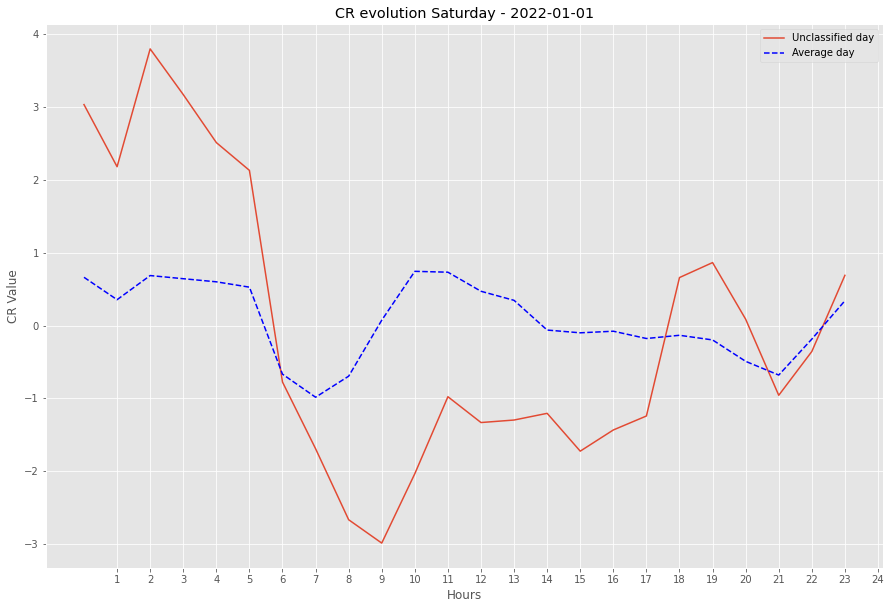

In [229]:
 # Crear la figura y el eje
fig, ax = plt.subplots(figsize=(15, 10))
#----------------------GRAFICA EVOLUCION DIA NO CLASIFICADO----------------------|
cr_values = filas.iloc[0].filter(regex='^CR\d{2}$').values
  # Graficar la evolución de la variable CR por Hours
ax.plot(cr_values, label='Unclassified day')
 

#----------------------GRAFICA EVOLUCION DIA NORMAL----------------------|
# Elegimos el dia
day = X_val['DIASEM_6'] == 1.0
# Seleccionar las filas que cumplen con el dia
selected_rows = X_val.loc[day]
# Calcular la media de las columnas CR00 a CR23
mean_CR = selected_rows.loc[:, 'CR00':'CR23'].mean(axis=0)
ax.plot(mean_CR,label='Average day', color='blue', linestyle='--')




 # Establecer el título y los ejes
ax.set_title(f"CR evolution Saturday - 2022-01-01")
ax.set_xlabel("Hours")
ax.set_ylabel("CR Value")

# Eje x
x_ticks = list(range(1, 25))
x_labels = [str(n) for n in x_ticks]
plt.xticks(x_ticks, x_labels)

#Leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

#### FILA 120 - MONDAY

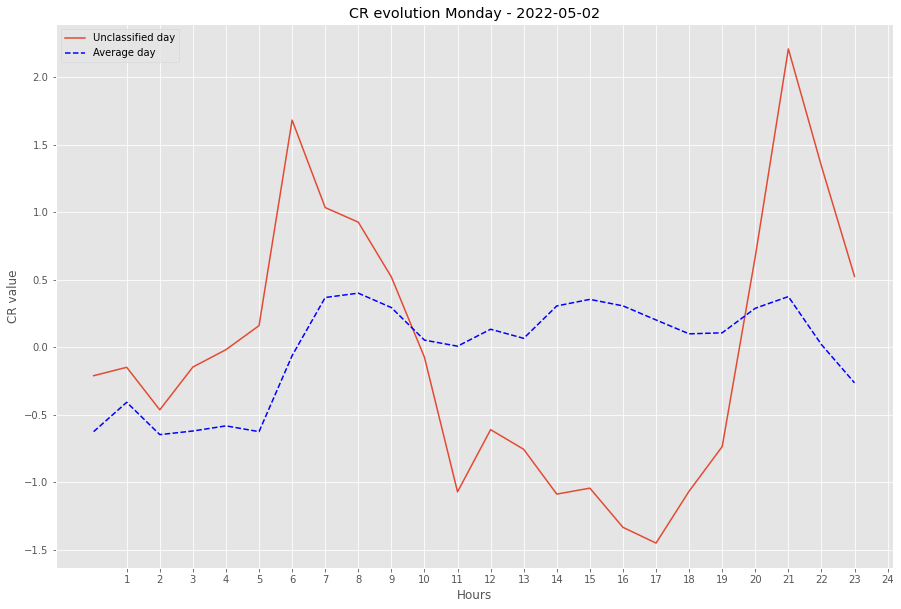

In [230]:
 # Crear la figura y el eje
fig, ax = plt.subplots(figsize=(15, 10))
#----------------------GRAFICA EVOLUCION DIA NO CLASIFICADO----------------------|
cr_values = filas.iloc[1].filter(regex='^CR\d{2}$').values
  # Graficar la evolución de la variable CR por horas
ax.plot(cr_values, label='Unclassified day')
 

#----------------------GRAFICA EVOLUCION DIA NORMAL----------------------|
# Elegimos el dia
day = X_val['DIASEM_1'] == 1.0
# Seleccionar las filas que cumplen con el dia
selected_rows = X_val.loc[day]
# Calcular la media de las columnas CR00 a CR23
mean_CR = selected_rows.loc[:, 'CR00':'CR23'].mean(axis=0)
ax.plot(mean_CR,label='Average day', color='blue', linestyle='--')




 # Establecer el título y los ejes
ax.set_title(f"CR evolution Monday - 2022-05-02")
ax.set_xlabel("Hours")
ax.set_ylabel("CR value")

# Eje x
x_ticks = list(range(1, 25))
x_labels = [str(n) for n in x_ticks]
plt.xticks(x_ticks, x_labels)

#Leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

#### FILA 232 - WEDNESDAY

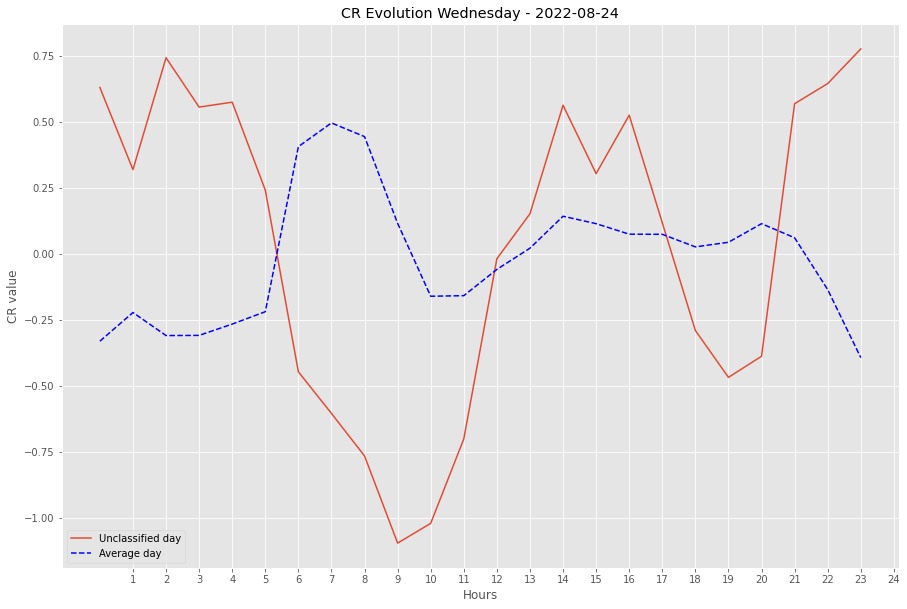

In [231]:
 # Crear la figura y el eje
fig, ax = plt.subplots(figsize=(15, 10))
#----------------------GRAFICA EVOLUCION DIA NO CLASIFICADO----------------------|
cr_values = filas.iloc[2].filter(regex='^CR\d{2}$').values
  # Graficar la evolución de la variable CR por horas
ax.plot(cr_values, label='Unclassified day')
 

#----------------------GRAFICA EVOLUCION DIA NORMAL----------------------|
# Elegimos el dia
day = X_val['DIASEM_3'] == 1.0
# Seleccionar las filas que cumplen con el dia
selected_rows = X_val.loc[day]
# Calcular la media de las columnas CR00 a CR23
mean_CR = selected_rows.loc[:, 'CR00':'CR23'].mean(axis=0)
ax.plot(mean_CR,label='Average day', color='blue', linestyle='--')




 # Establecer el título y los ejes
ax.set_title(f"CR Evolution Wednesday - 2022-08-24")
ax.set_xlabel("Hours")
ax.set_ylabel("CR value")

# Eje x
x_ticks = list(range(1, 25))
x_labels = [str(n) for n in x_ticks]
plt.xticks(x_ticks, x_labels)

#Leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

These days show a very different curve to the expected behaviour, which may be the reason why the model has failed to classify these days.